In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import loompy
import anndata

sc.settings.verbosity = 3     
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
adata = sc.read_loom('good.loom', X_name='spliced', obs_names='cellID', var_names='GeneName', dtype='float32',validate=False)
adata.obs_names_make_unique() 

sc.pp.log1p(adata)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


scanpy==1.9.1 anndata==0.7.5 umap==0.4.6 numpy==1.21.2 scipy==1.5.3 pandas==1.5.2 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.9.9 louvain==0.7.0 leidenalg==0.8.1


In [2]:
adata_celltypes={}
df={}
gbi={}

celltypes=['Pericyte','Car4+ capillaries','Early Car4- capillaries','Nonproliferative embryonic EC','Late Car4- capillaries']

for celltype in celltypes:
    adata_celltypes[celltype]=adata[adata.obs['cellSubtype']==celltype]
    df[celltype]=adata_celltypes[celltype].obs.copy()
    gbi[celltype]=df[celltype].groupby('Timepoint')

adata_celltypes.keys()

dict_keys(['Pericyte', 'Car4+ capillaries', 'Early Car4- capillaries', 'Nonproliferative embryonic EC', 'Late Car4- capillaries'])

In [3]:
timepoints=['E18.5','P1','P7','P21','P7_HO']

adata_d={}
for timepoint in timepoints:

    key=('Pericyte',timepoint)
    adata_d[key]=adata_celltypes['Pericyte'][adata_celltypes['Pericyte'].obs['TimepointHO']==timepoint]
    
    if timepoint=='E18.5':
        key=('Car4+ capillaries',timepoint)
        adata_d[key]=adata_celltypes['Nonproliferative embryonic EC'][adata_celltypes['Nonproliferative embryonic EC'].obs['TimepointHO']==timepoint]
        #continue #to do
    else:
        key=('Car4+ capillaries',timepoint)
        adata_d[key]=adata_celltypes['Car4+ capillaries'][adata_celltypes['Car4+ capillaries'].obs['TimepointHO']==timepoint]
  
    if timepoint=='E18.5':
        key=('Car4- capillaries',timepoint)
        adata_d[key]=adata_celltypes['Nonproliferative embryonic EC'][adata_celltypes['Nonproliferative embryonic EC'].obs['TimepointHO']==timepoint]
        #continue #to do
    elif timepoint=='P21':
        key=('Car4- capillaries',timepoint)
        adata_d[key]=adata_celltypes['Late Car4- capillaries'][adata_celltypes['Late Car4- capillaries'].obs['TimepointHO']==timepoint]
    else:
        key=('Car4- capillaries',timepoint)
        adata_d[key]=adata_celltypes['Early Car4- capillaries'][adata_celltypes['Early Car4- capillaries'].obs['TimepointHO']==timepoint]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


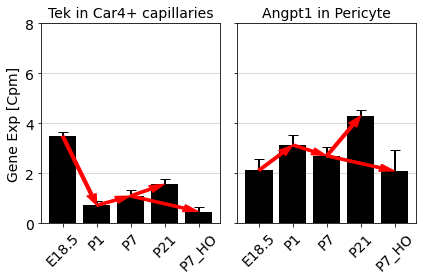

In [6]:
pairs_Car4=[
    ['Tek', 'Angpt1'],
#     ['Dll4','Notch3'], ['Pdgfb', 'Pdgfrb'], ['Dll4', 'Dll4']
           ]
pairs_Early_Car4=[
#     ['Dll4','Notch3'], ['Pdgfb', 'Pdgfrb'],
                 ]
pairs_pericyte=[
               ]

pairs_cts=[['Car4+ capillaries','Pericyte'],['Early Car4- capillaries','Pericyte'],['Pericyte','Pericyte']]
pairs_dic={'Car4+ capillaries':pairs_Car4,'Early Car4- capillaries':pairs_Early_Car4,'Pericyte':pairs_pericyte}
adata_dic={
            'Pericyte':[
                    adata_d[('Pericyte','E18.5')],
                    adata_d[('Pericyte','P1')],
                    adata_d[('Pericyte','P7')],
                    adata_d[('Pericyte','P21')],
                    adata_d[('Pericyte','P7_HO')]
                        ],
           'Car4+ capillaries':[
                    adata_d[('Car4+ capillaries','E18.5')],
                    adata_d[('Car4+ capillaries','P1')],
                    adata_d[('Car4+ capillaries','P7')],
                    adata_d[('Car4+ capillaries','P21')],
                    adata_d[('Car4+ capillaries','P7_HO')]
                       ],
           'Early Car4- capillaries':[
                    adata_d[('Car4- capillaries','E18.5')],
                    adata_d[('Car4- capillaries','P1')],
                    adata_d[('Car4- capillaries','P7')],
                    adata_d[('Car4- capillaries','P21')],
                    adata_d[('Car4- capillaries','P7_HO')]
                       ]
          }

timepoint=['E18.5','P1','P7','P21','P7_HO']
y_gene_ct=[{},{}] #为了使用for循环产生y_gene1_ct1(y_gene_ct[0])和y_gene2_ct2(y_gene_ct[1])

for ct in pairs_cts: #ct is a list,ct[0]=ct1,ct[1]=ct2
    pairs=pairs_dic[ct[0]]
    for gene in pairs:
        fig,axs=plt.subplots(1,2,figsize=(6,4),sharey=True)#sharey=True一横排共享一个y轴
        for k,(gene_k,ct_k) in enumerate(zip(gene,ct)): #k代表的是数字，y_gene_ct[k]是dic，对应的key是（gene，ct）
            y_gene_ct[k][(gene_k,ct_k)]=[]
            x=[0,1,2,3,4]
            y=[]
            sem_gene_ct=[]
            x_arrow=[0,1,2,3,4]
            y_arrow=[] 
            #for loop添加元素之前先定义empty list
            for j,tp in enumerate(timepoint):
                gene_ct=adata_dic[ct_k][j][:,gene_k].X.toarray()[:,0]
                y_gene_ct[k][(gene_k,ct_k)].append(gene_ct)
                y.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
                sem_gene_ct.append((y_gene_ct[k][(gene_k,ct_k)][j]).std()/np.sqrt((y_gene_ct[k][(gene_k,ct_k)][j]).size))
                y_arrow.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
                
            ax=axs[k]
            ax=sns.barplot(x,y,label='_nolegend_',lw=2,ax=ax,color='black',zorder=10) 
            # label='_nolegend_'，legend没有这个图的；zorder把grid隐到后面
            ax.errorbar(x,y,yerr=sem_gene_ct,color='black',ls='',capsize=5,label='sem',lw=2)
            ax.set_title(gene_k+' in '+ct_k)
            ax.set_ylim(0,8)
            ax.set_xticklabels(['E18.5','P1','P7','P21','P7_HO'],rotation=45)
            for a in range(3): #E18.5-P1,P1-P7,P7-P21的箭头
                ax.arrow(x_arrow[a],y_arrow[a],x_arrow[a+1]-x_arrow[a],y_arrow[a+1]-y_arrow[a],length_includes_head=True,color='red',zorder=10,width=0.1)
            ax.arrow(x_arrow[2],y_arrow[2],x_arrow[4]-x_arrow[2],y_arrow[4]-y_arrow[2],length_includes_head=True,color='red',zorder=10,width=0.1) 
            # P7和P7_HO的箭头
            if k==0:
                ax.set_ylabel('Gene Exp [Cpm]') 
                #设置左图的label
        plt.tight_layout()
        plt.subplots_adjust(left=0.1)

<ipython-input-134-2f2a2ce8d62a>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs=plt.subplots(1,2,figsize=(6,4),sharey=True)#sharey=True一横排共享一个y轴


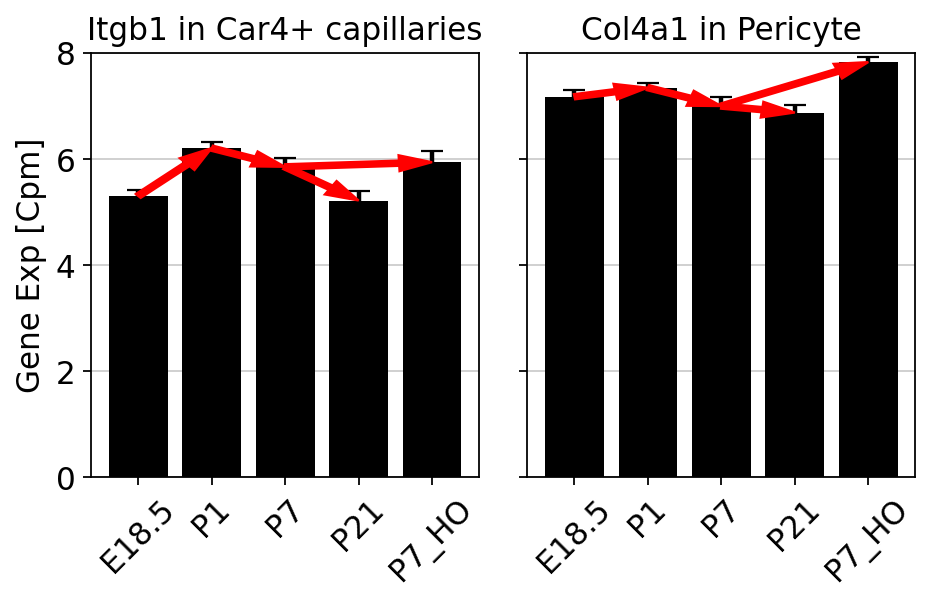

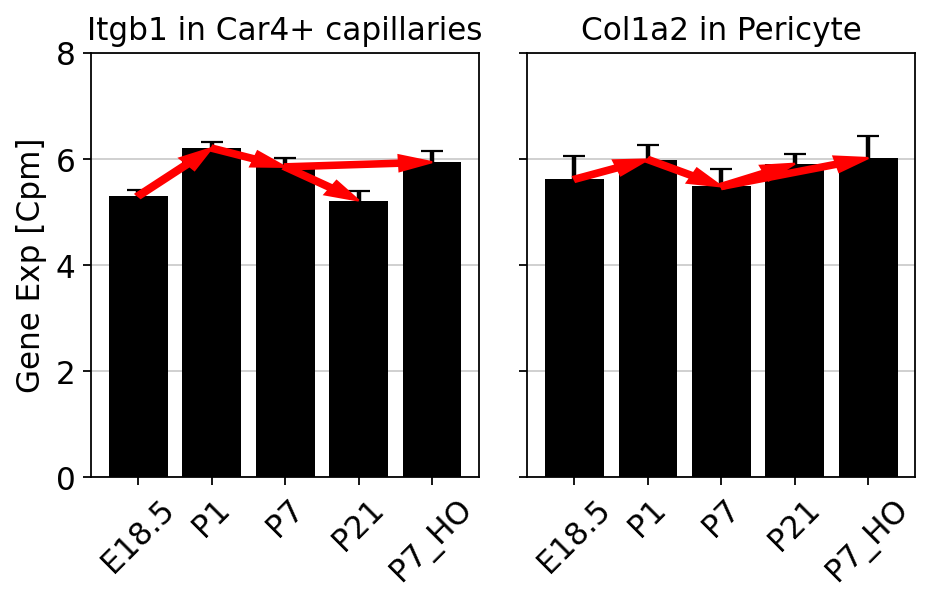

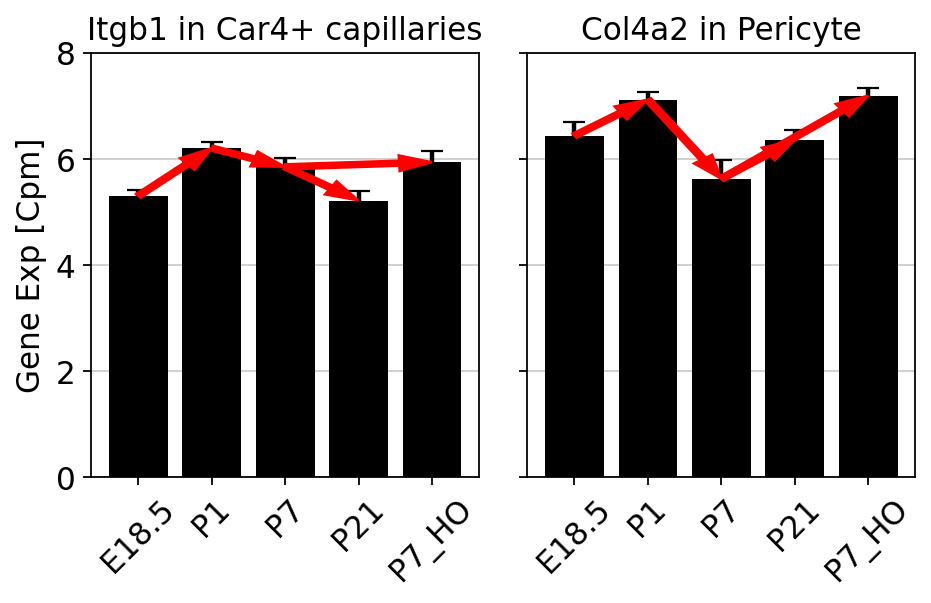

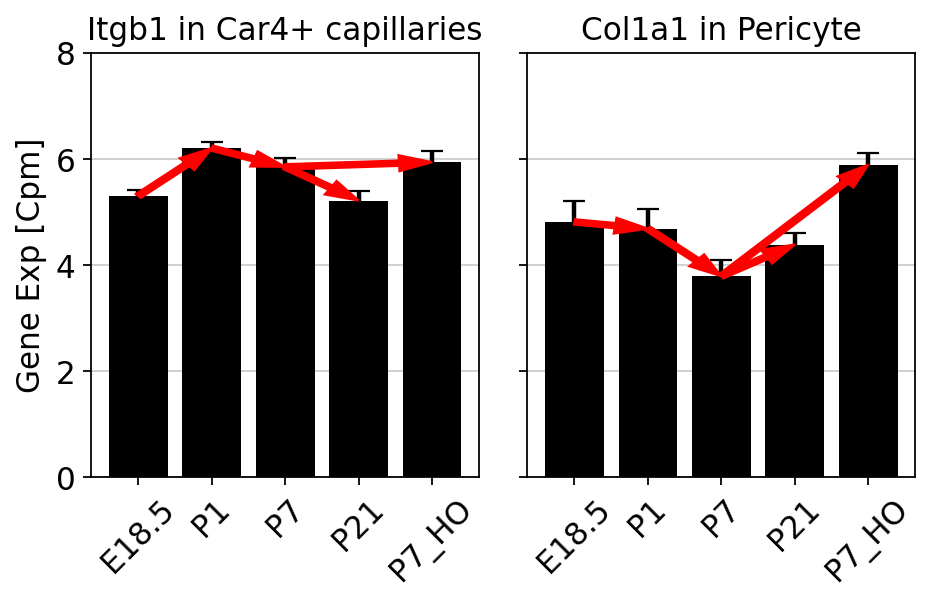

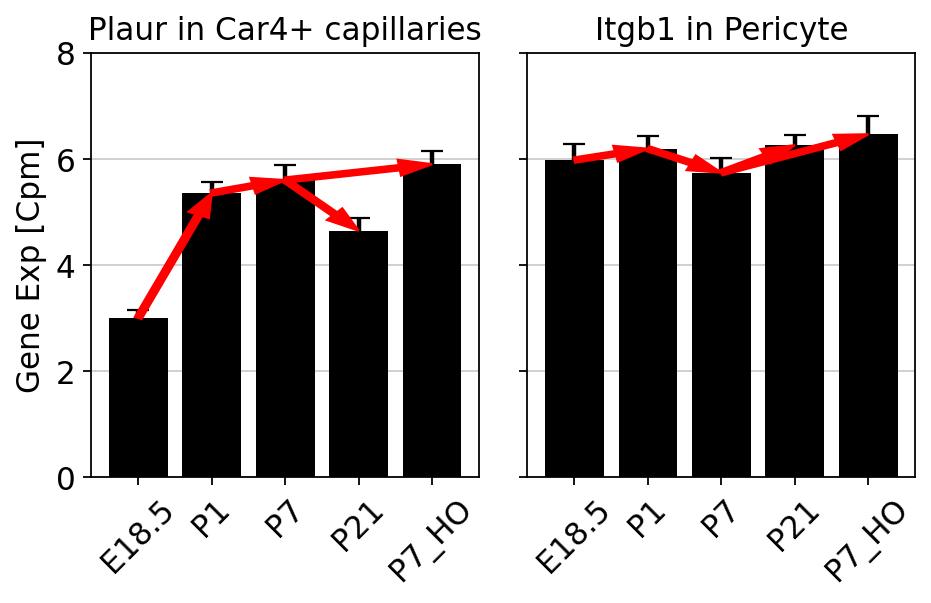

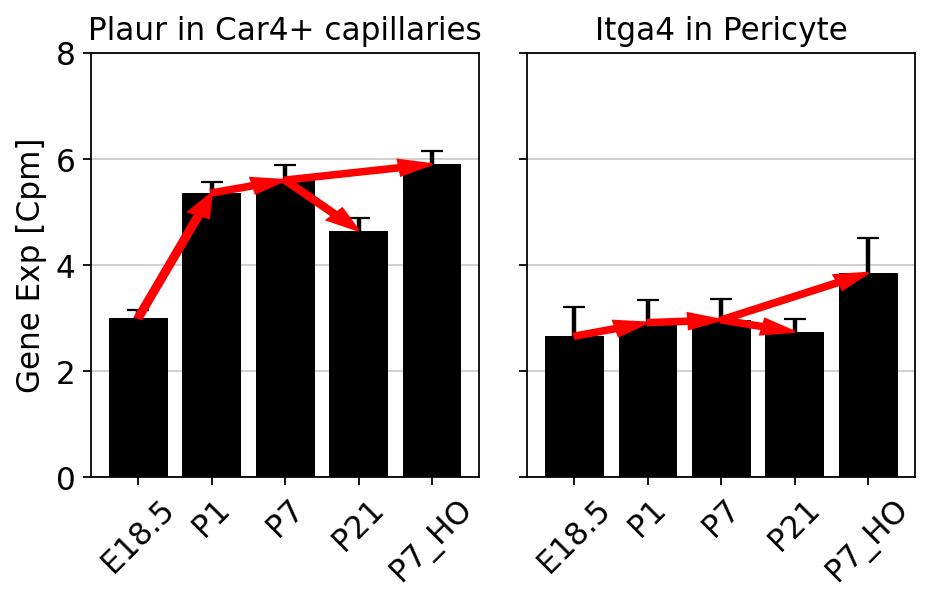

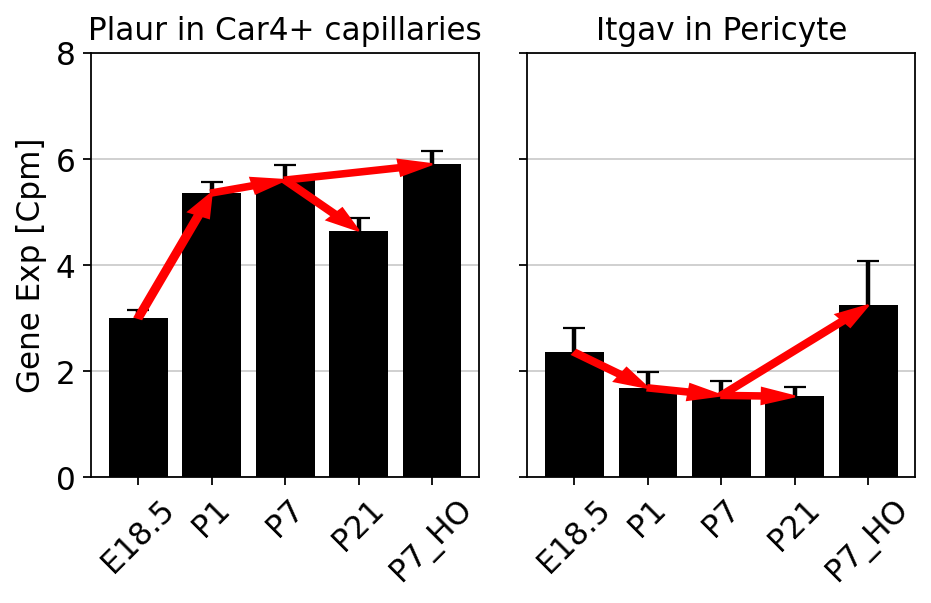

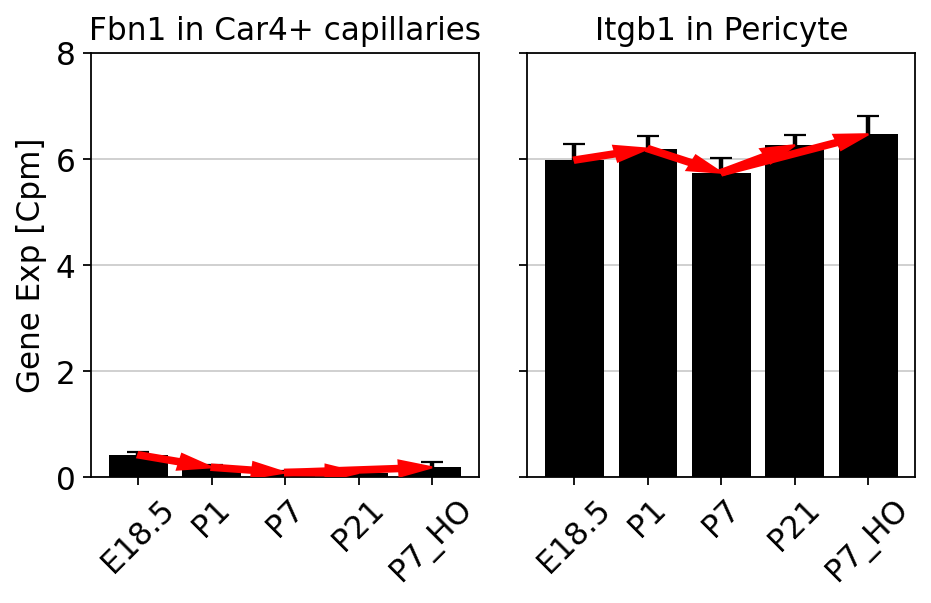

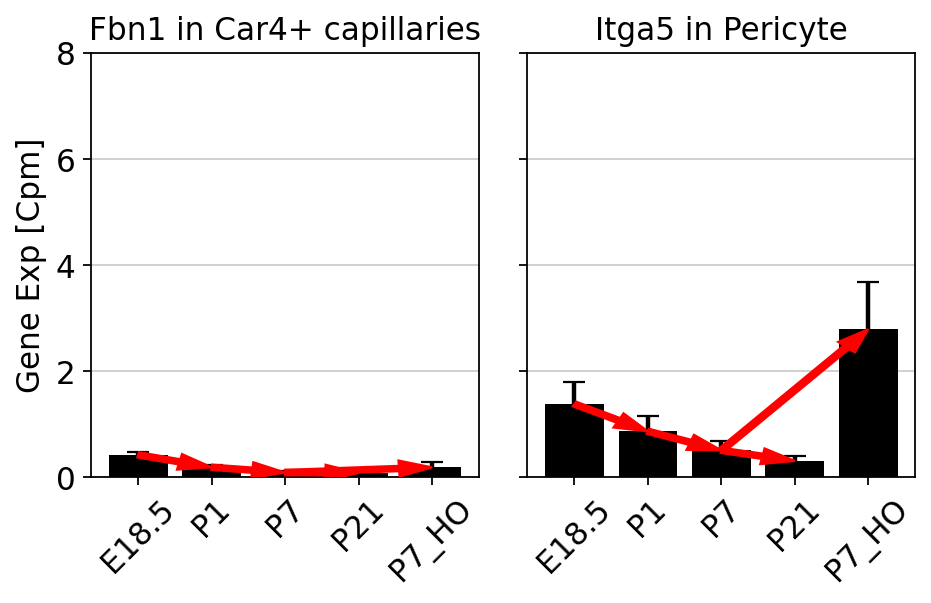

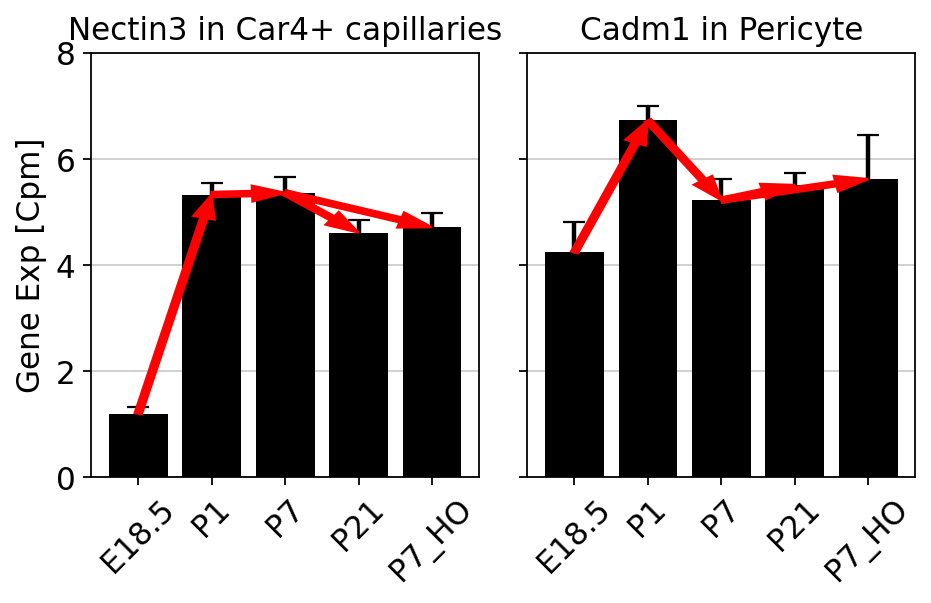

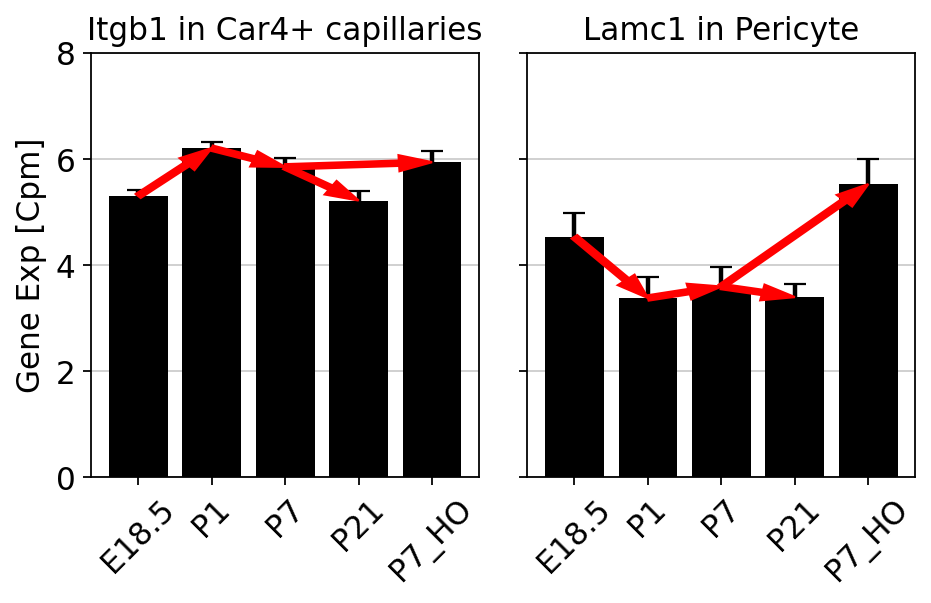

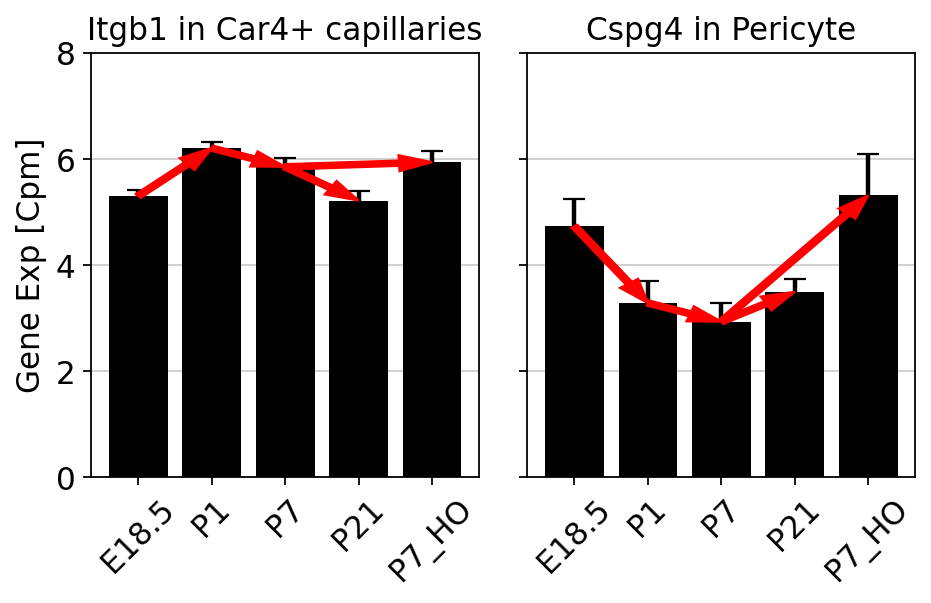

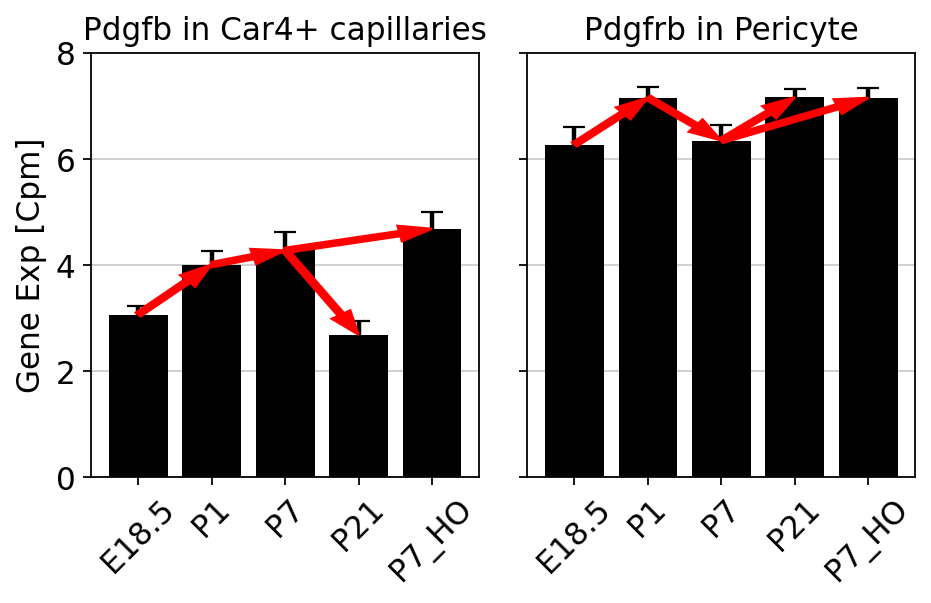

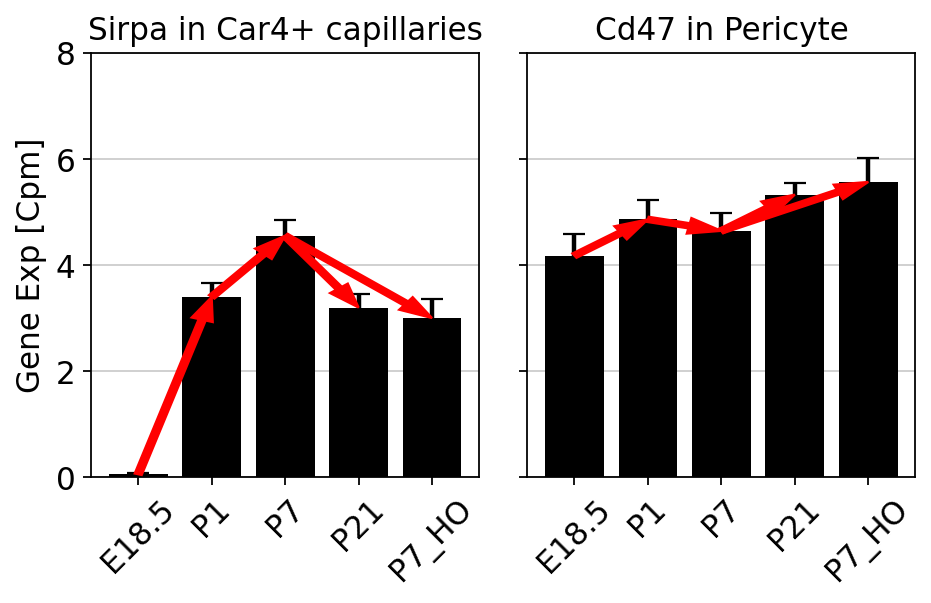

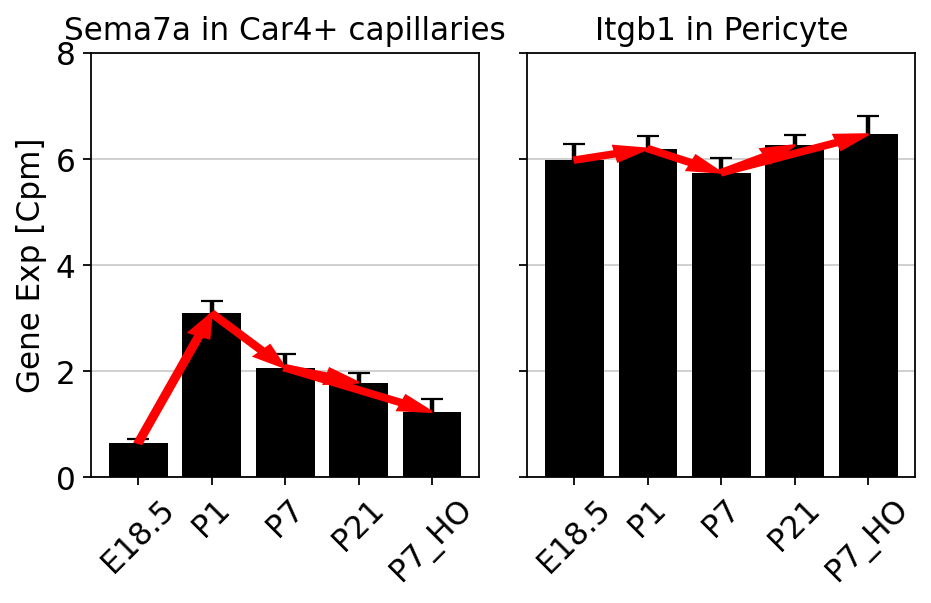

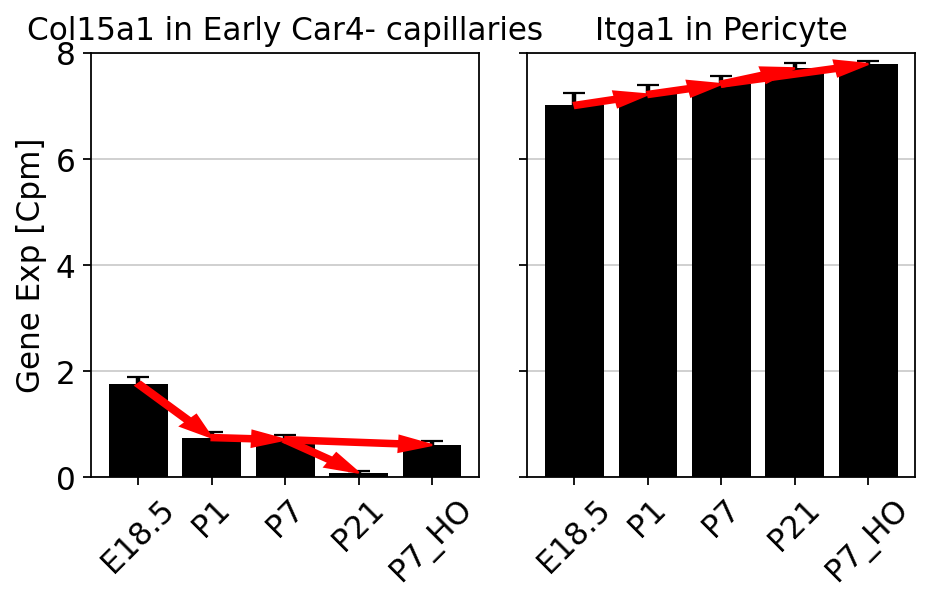

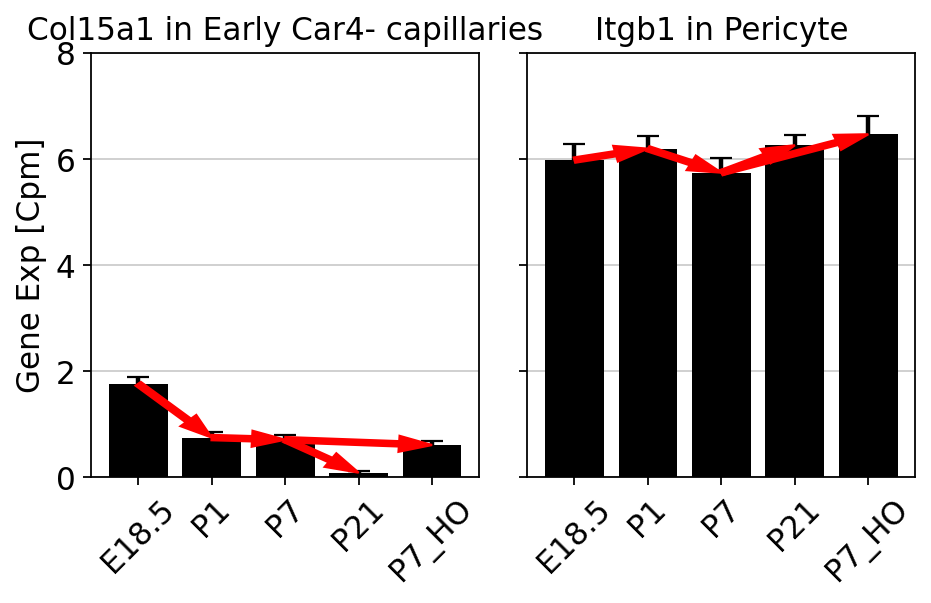

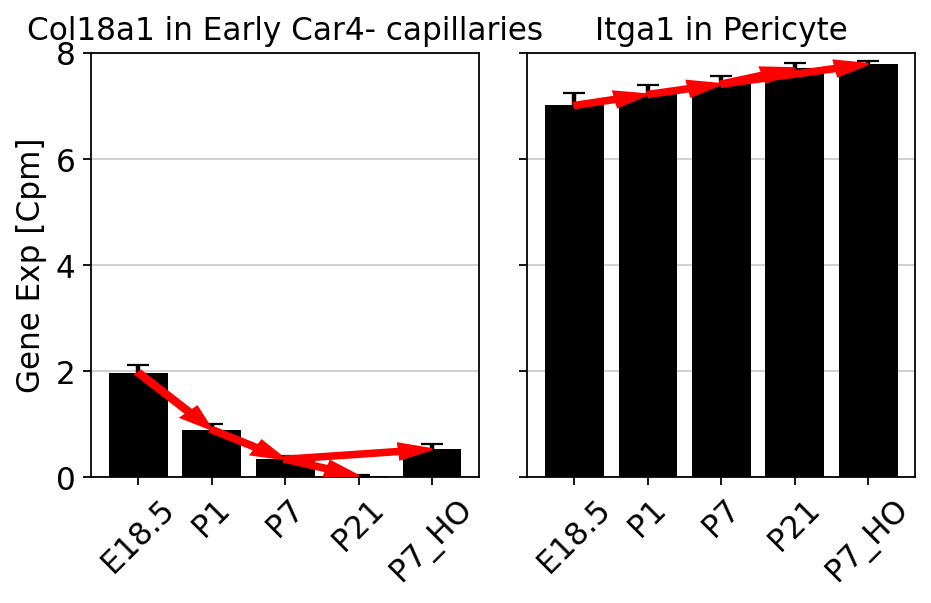

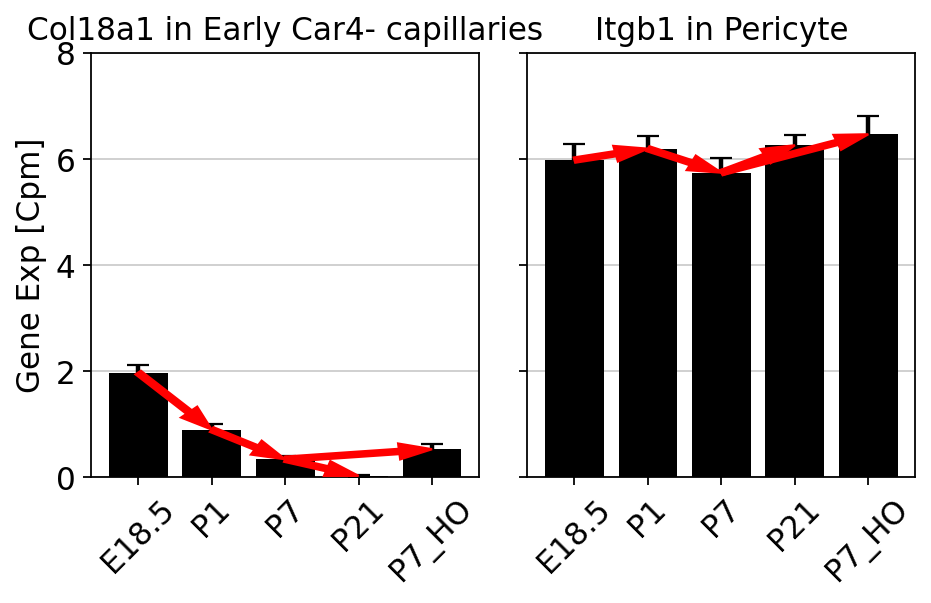

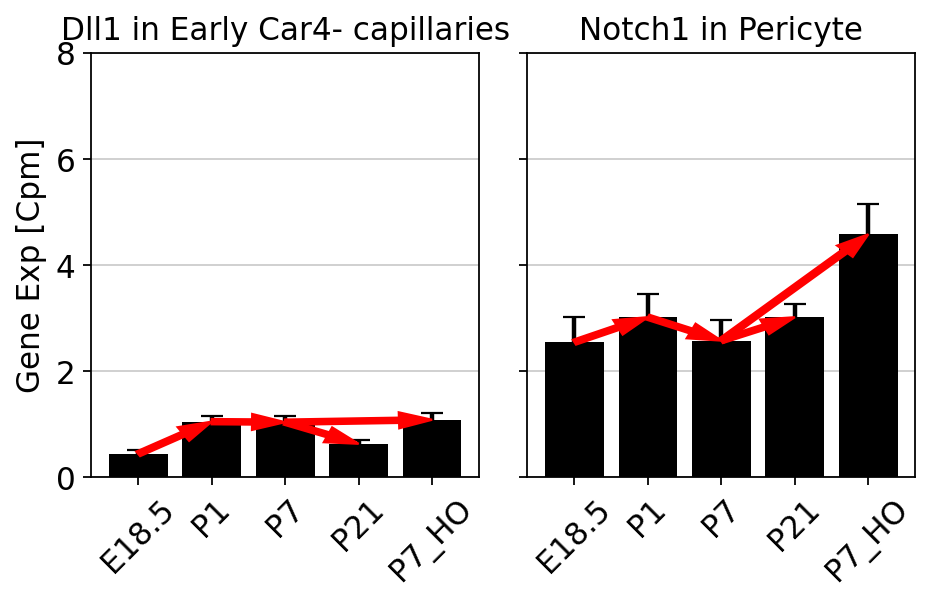

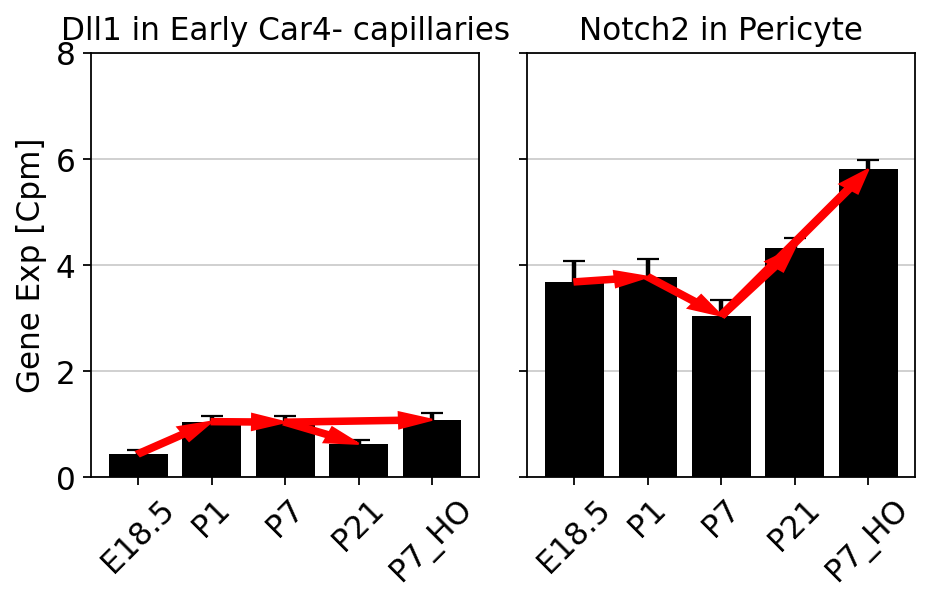

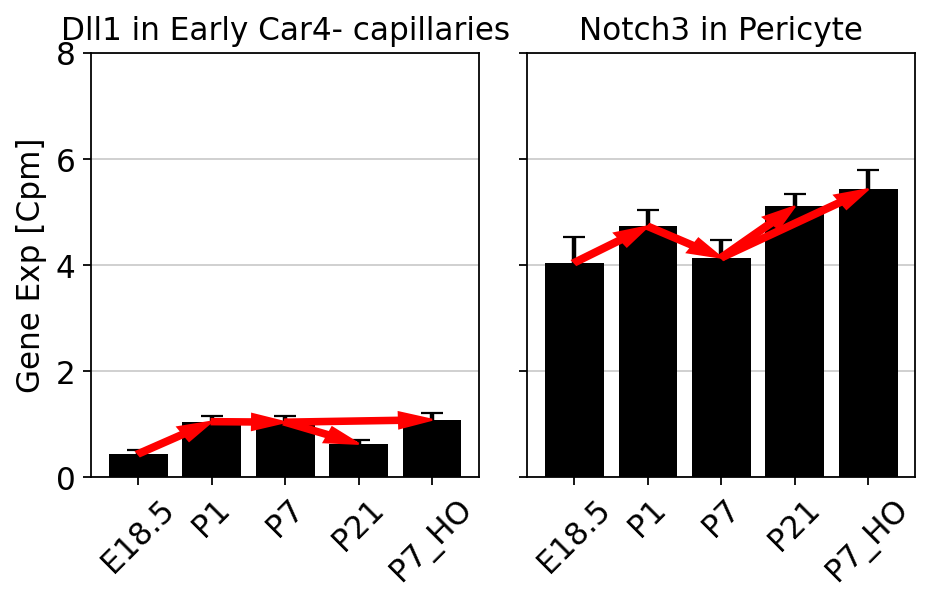

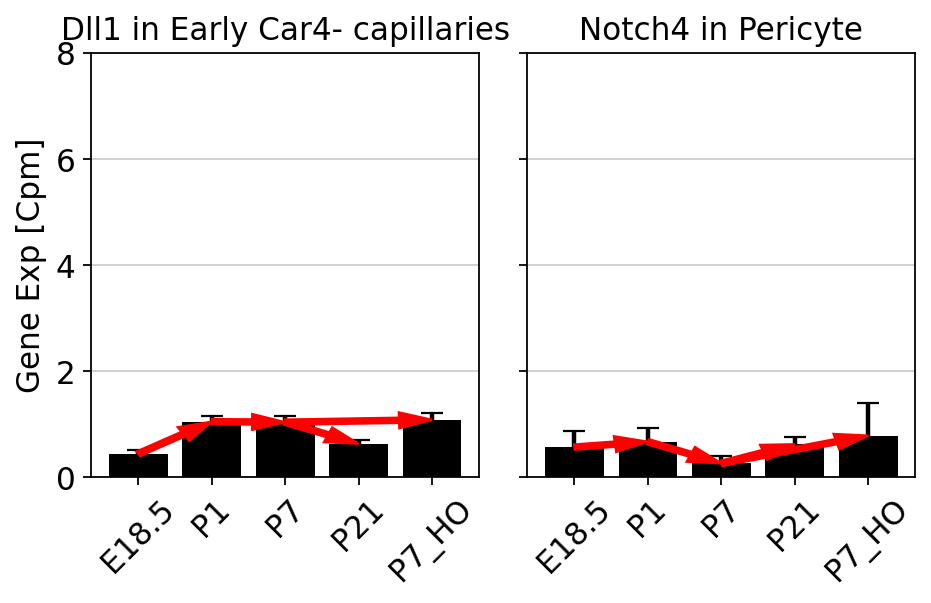

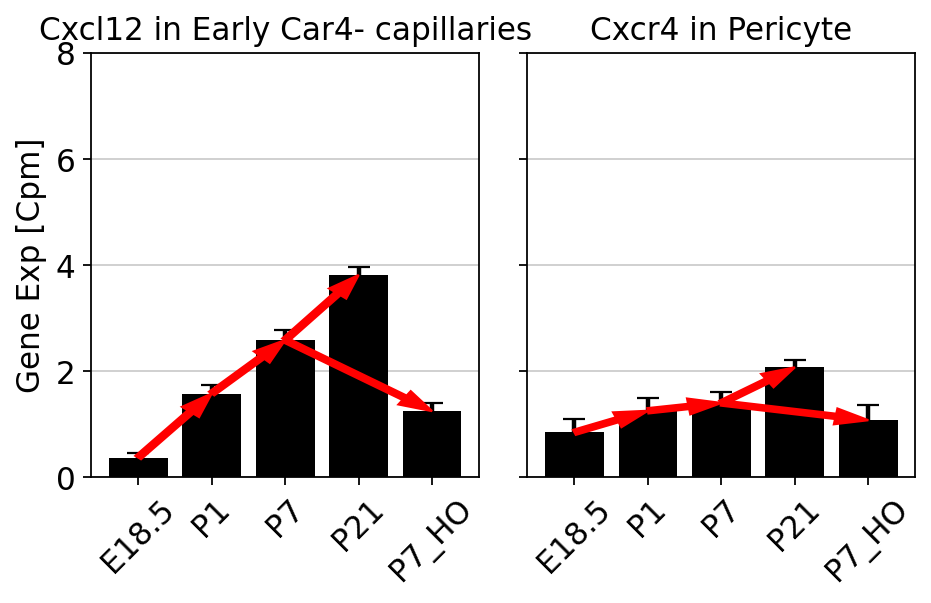

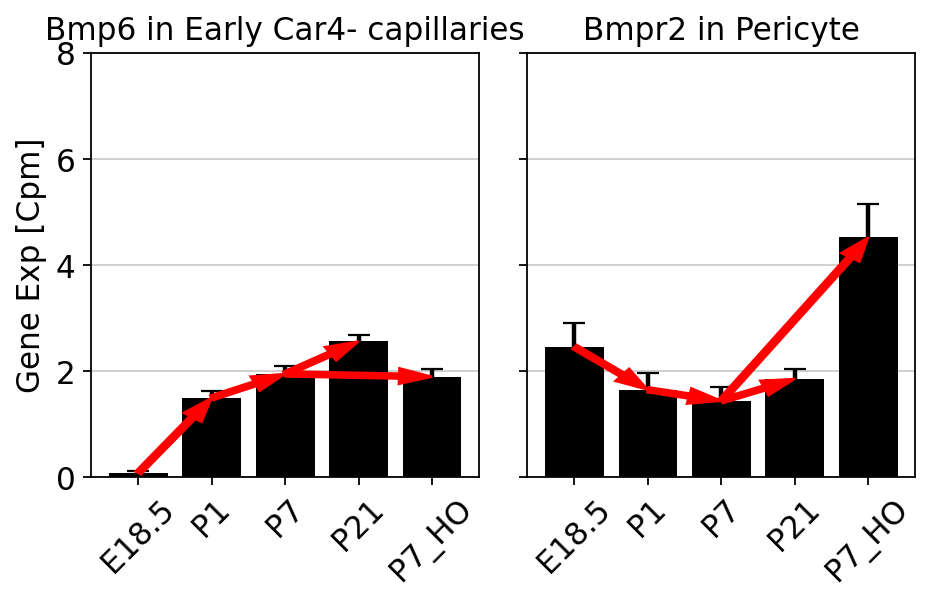

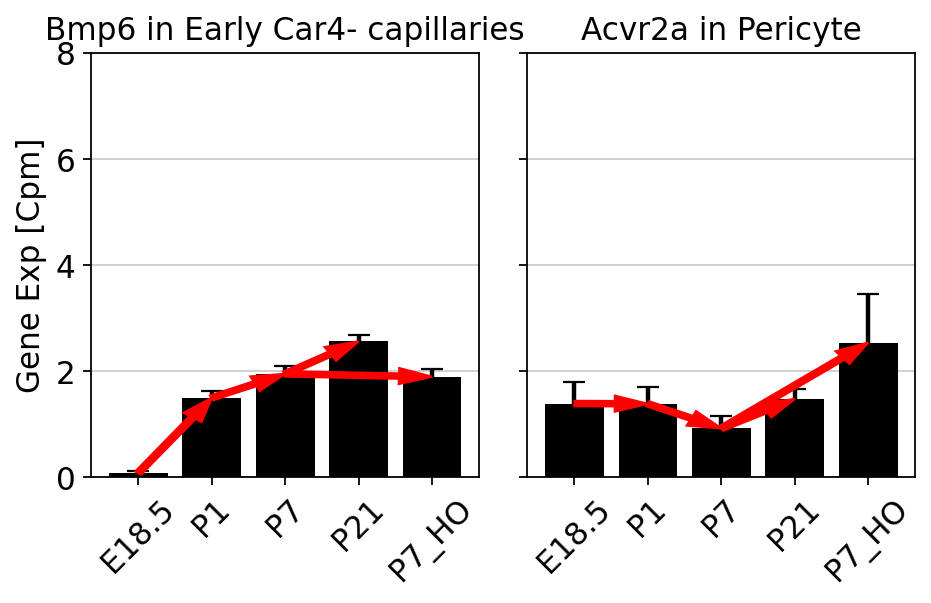

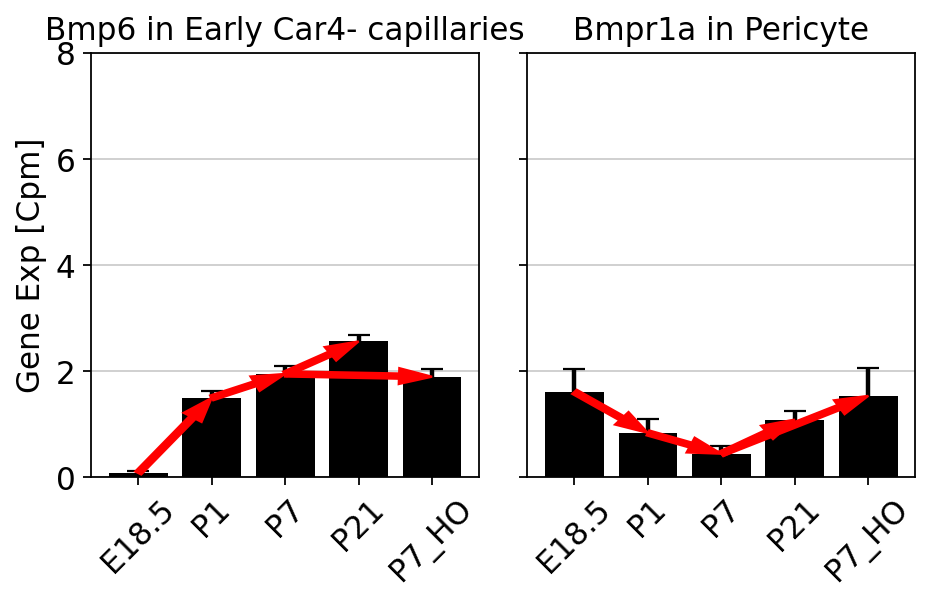

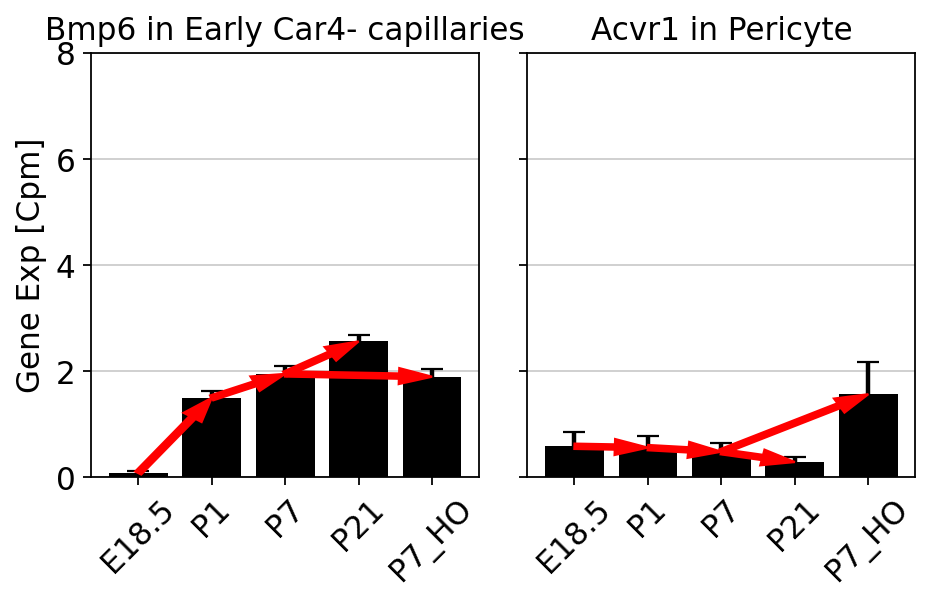

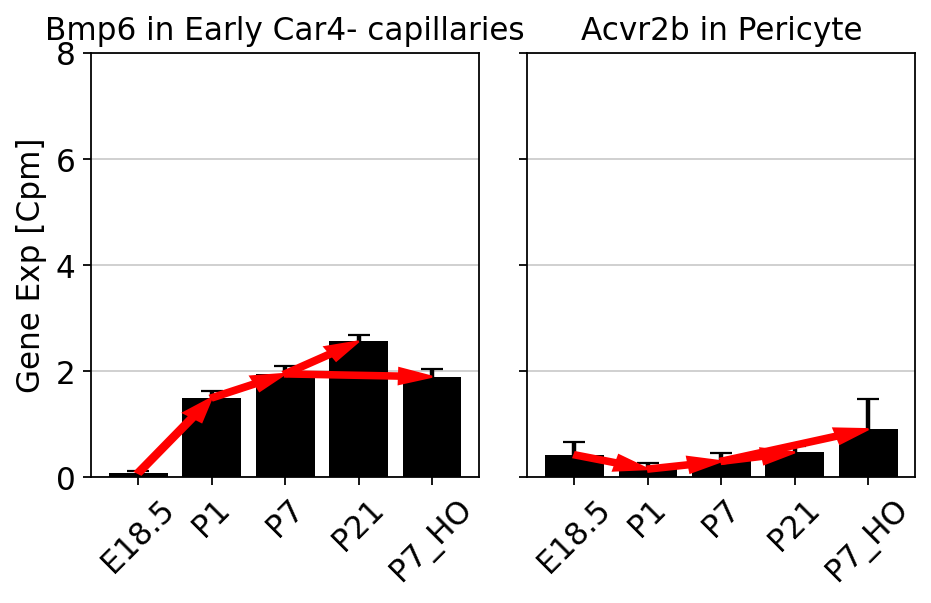

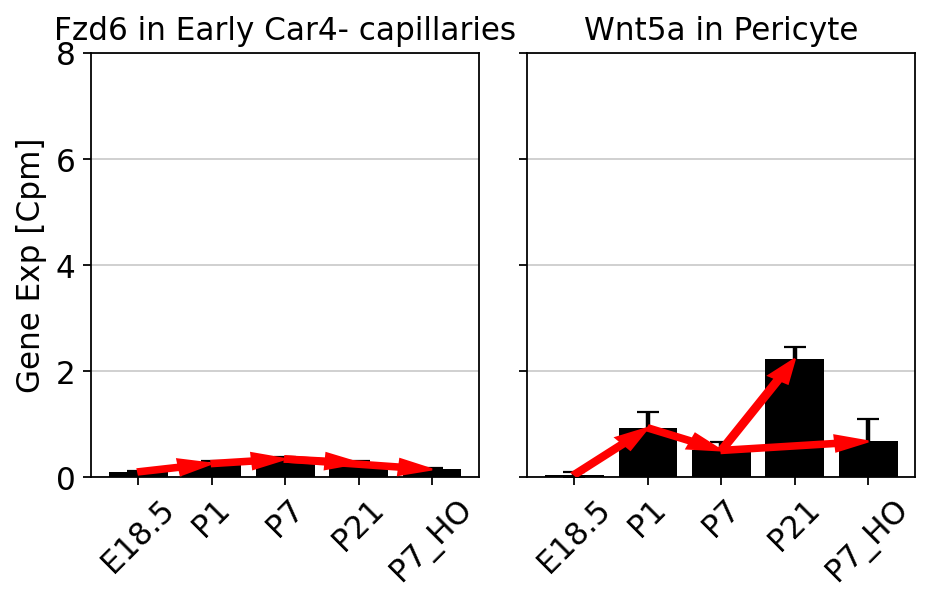

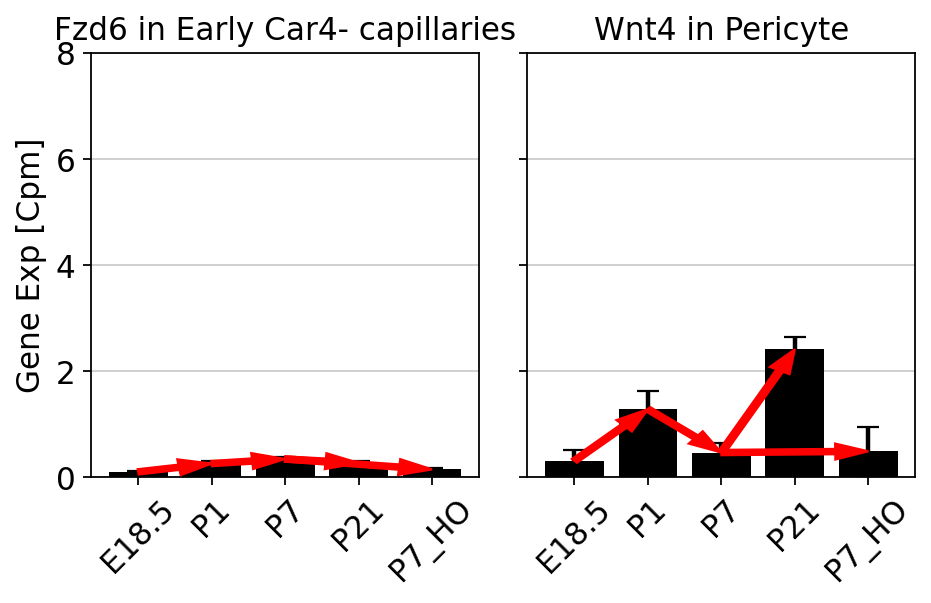

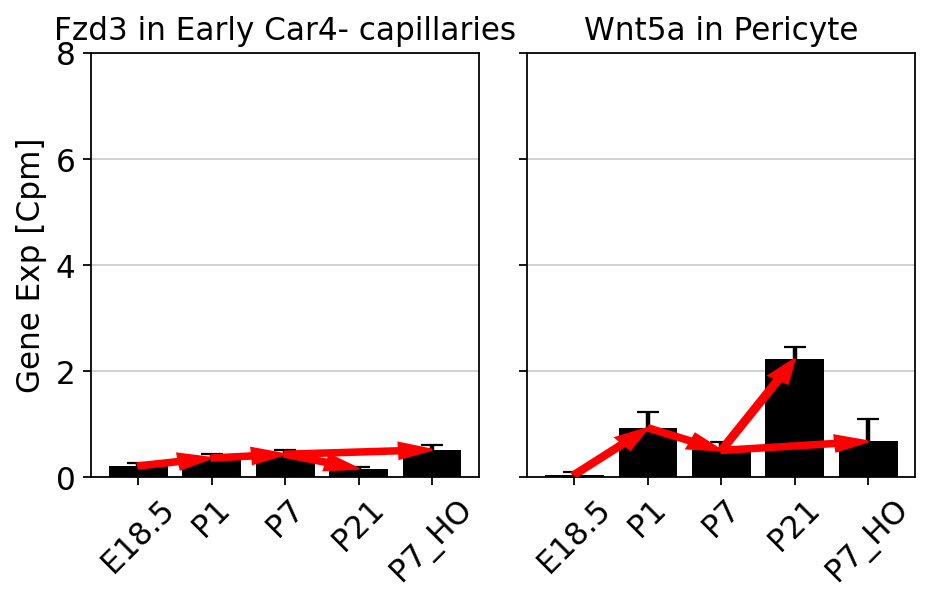

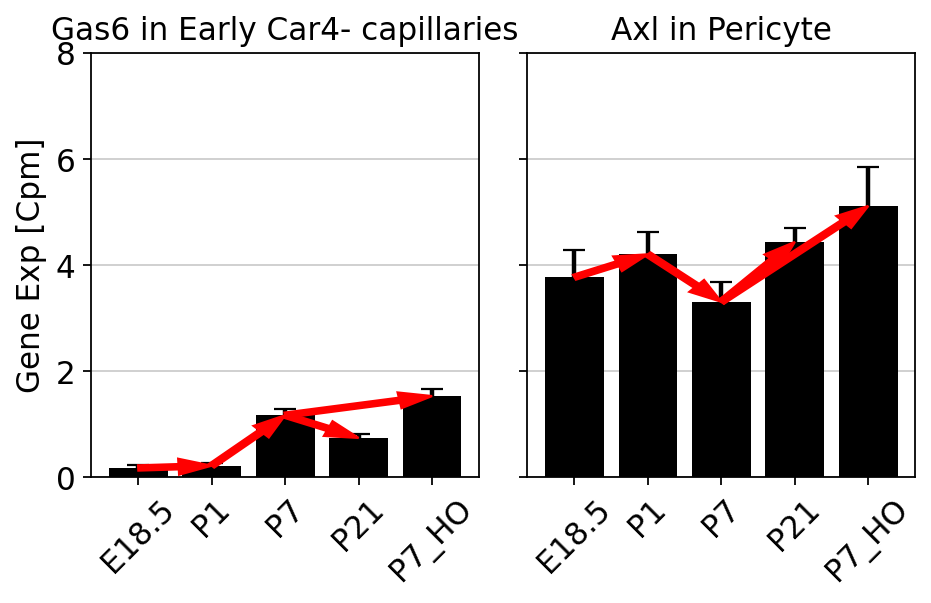

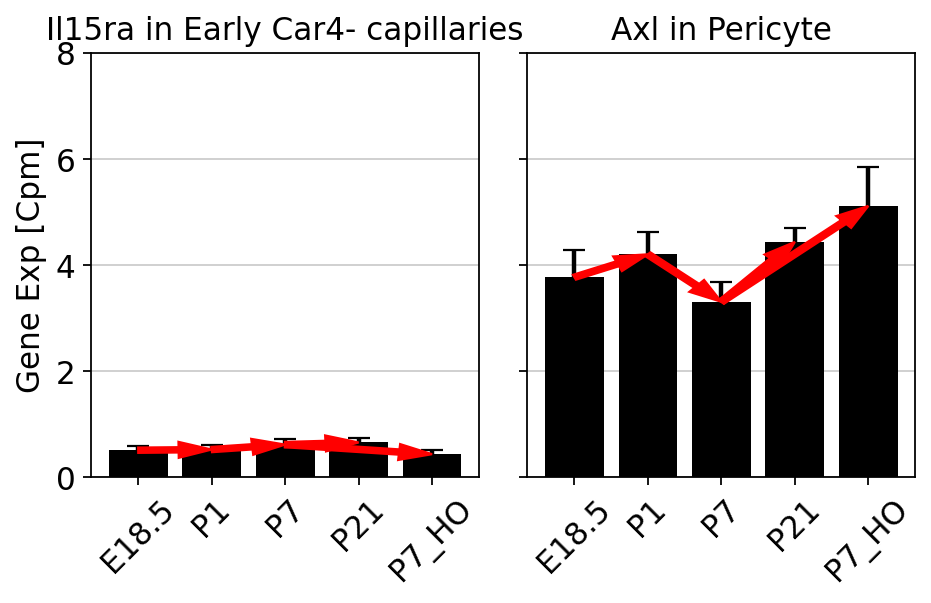

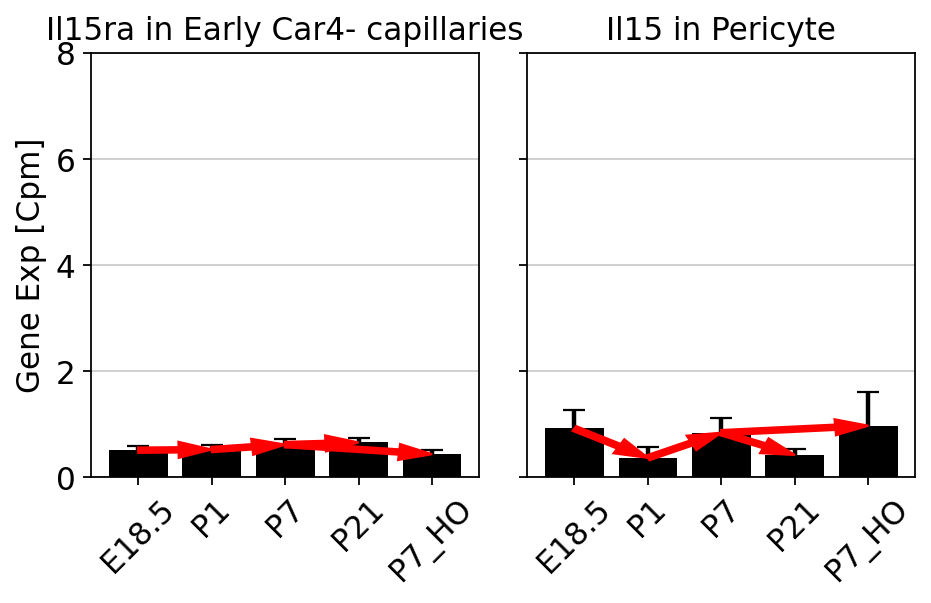

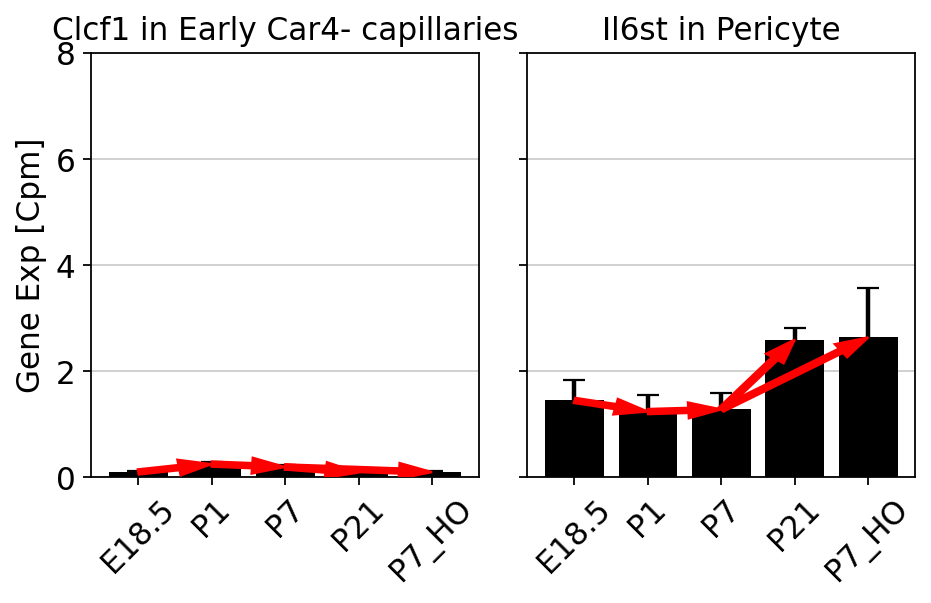

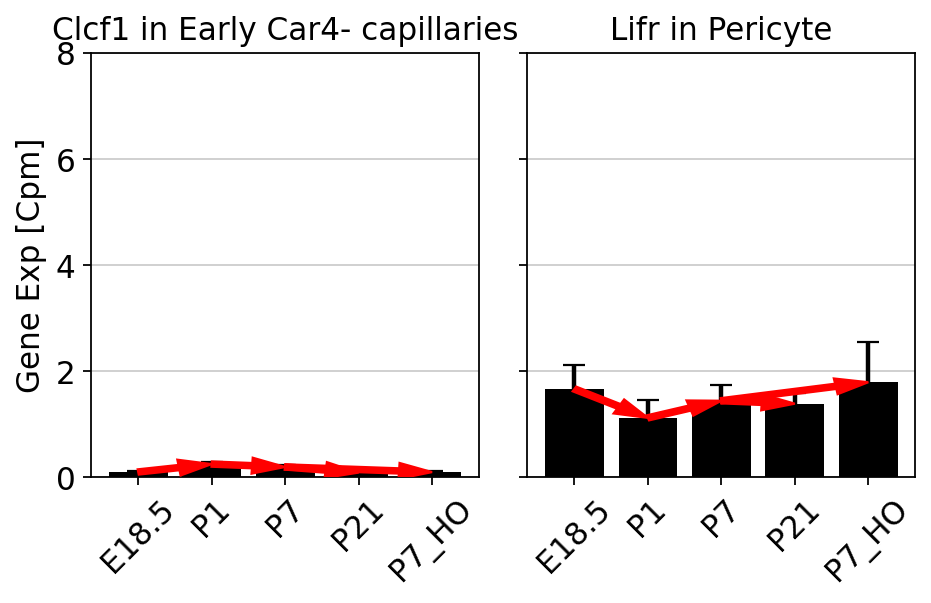

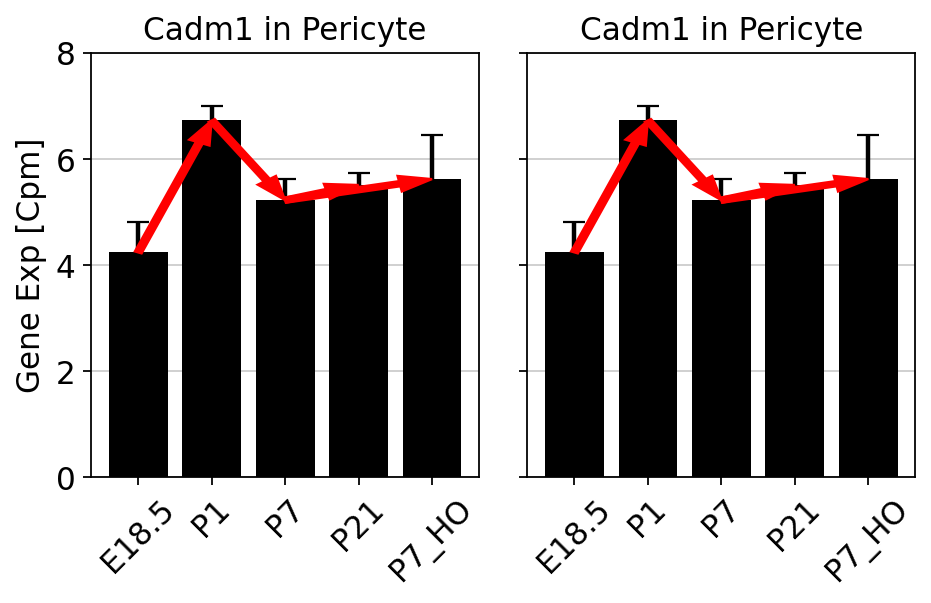

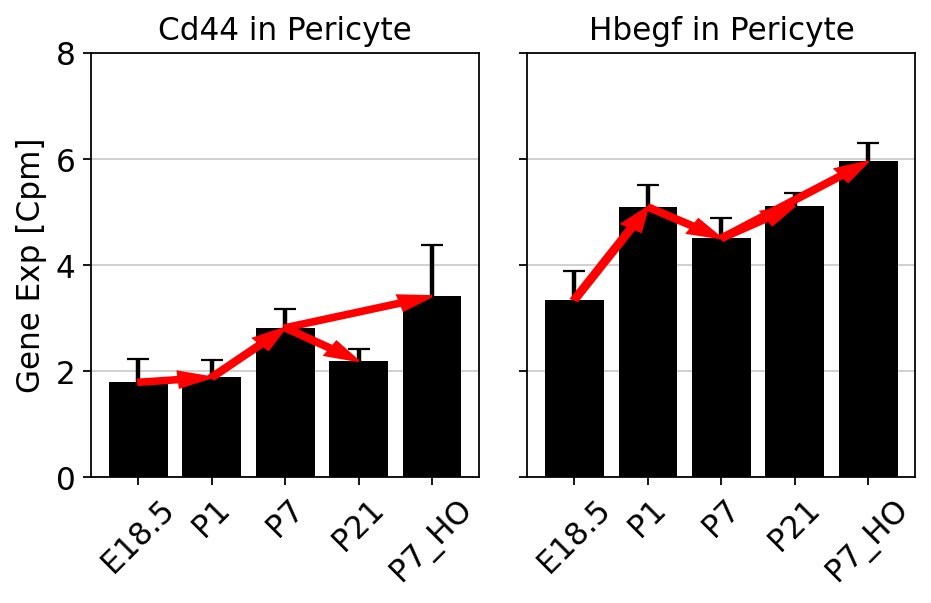

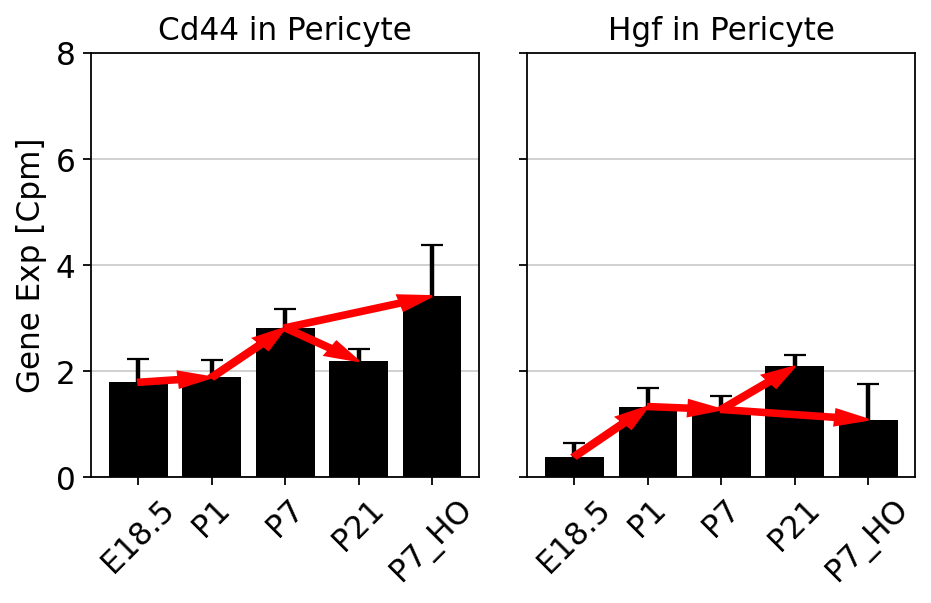

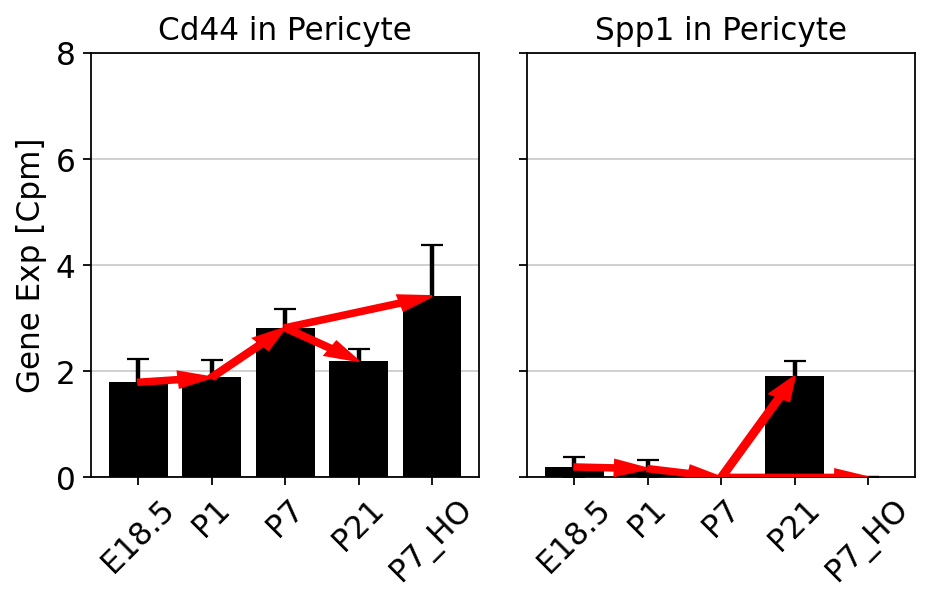

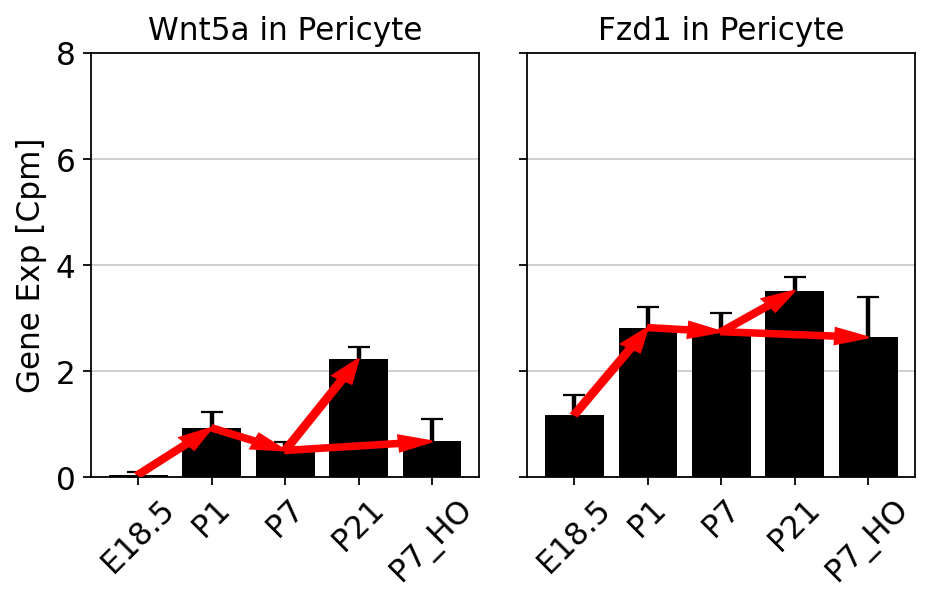

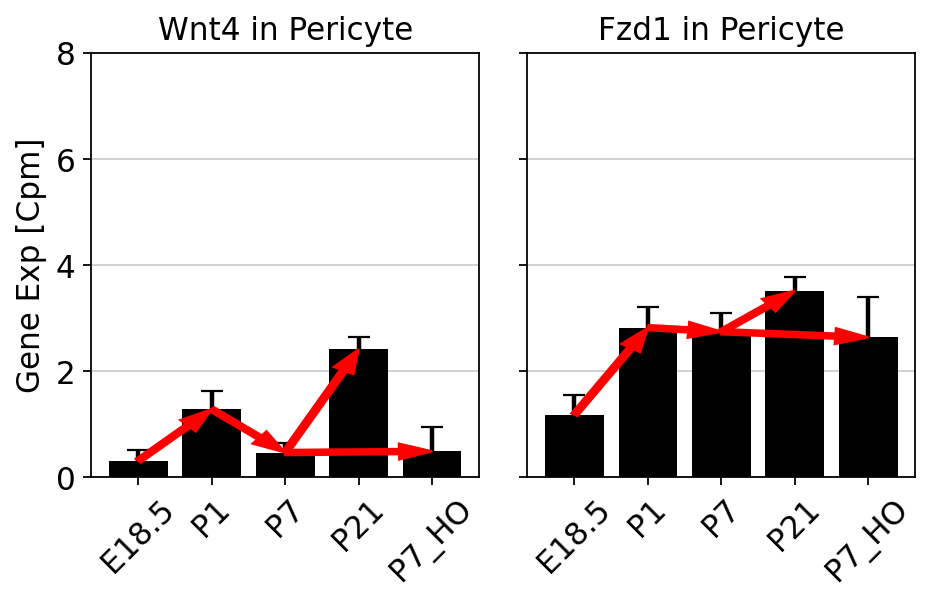

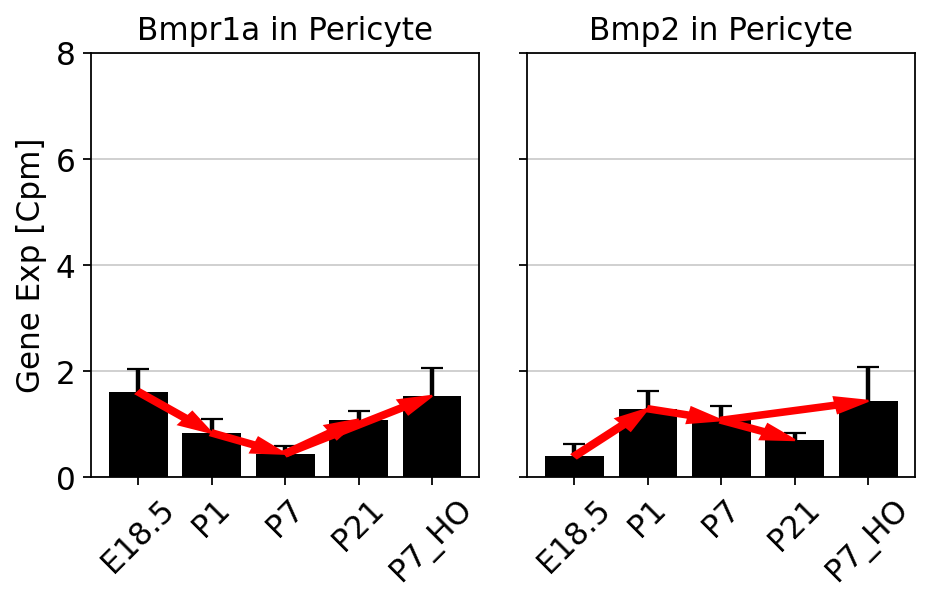

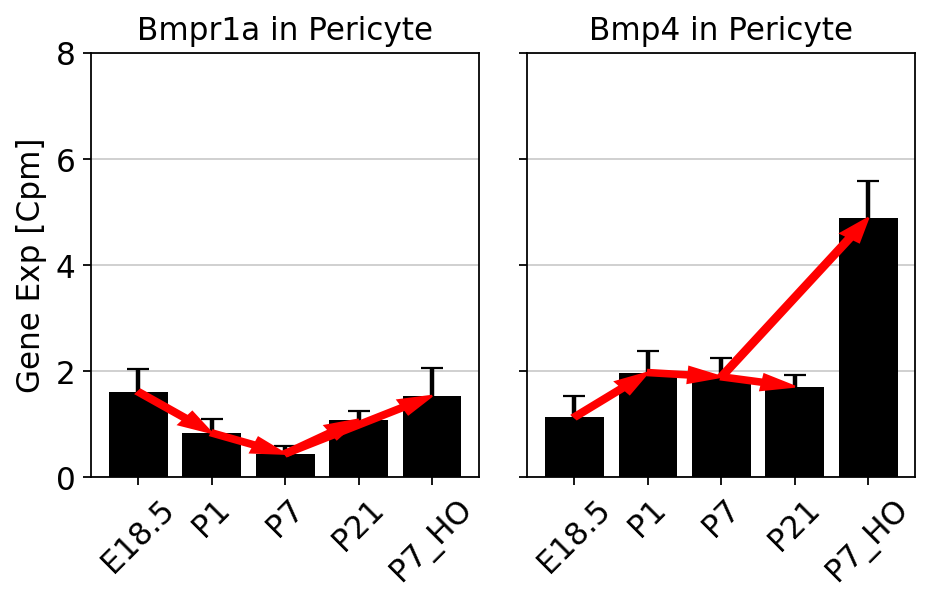

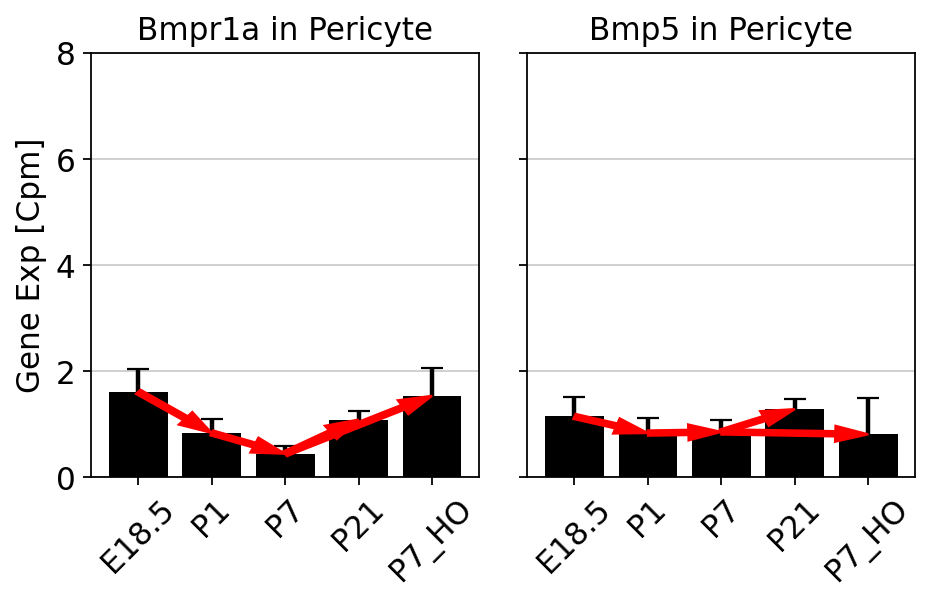

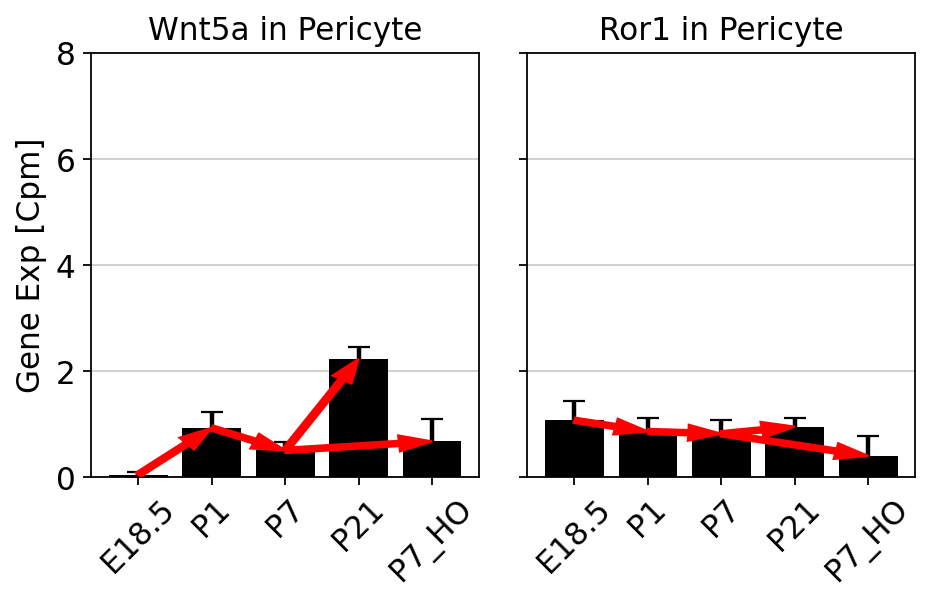

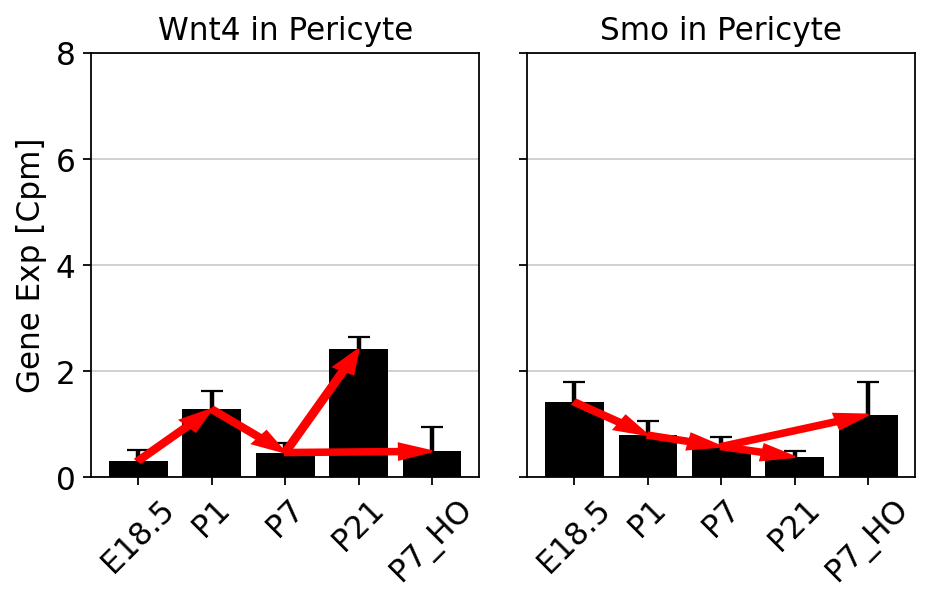

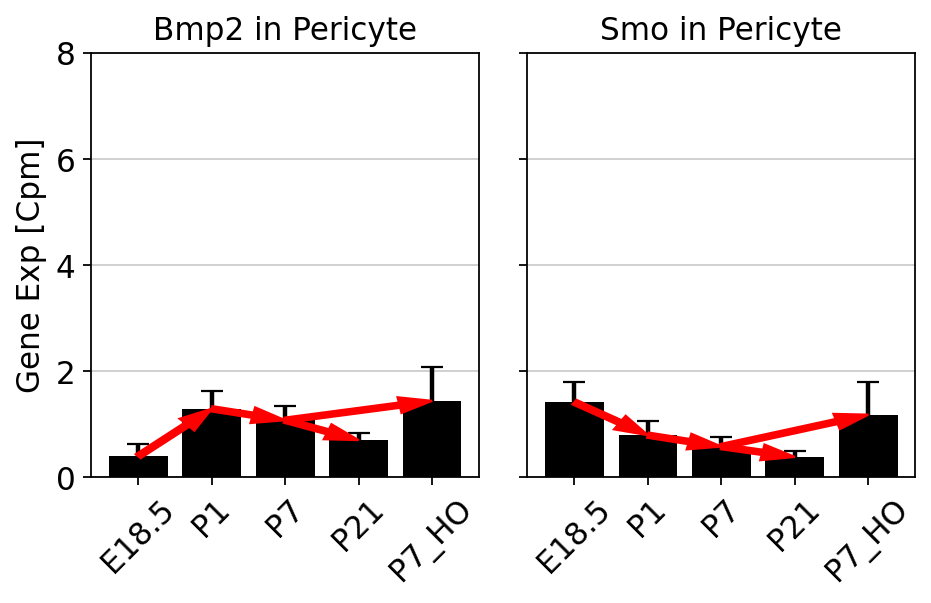

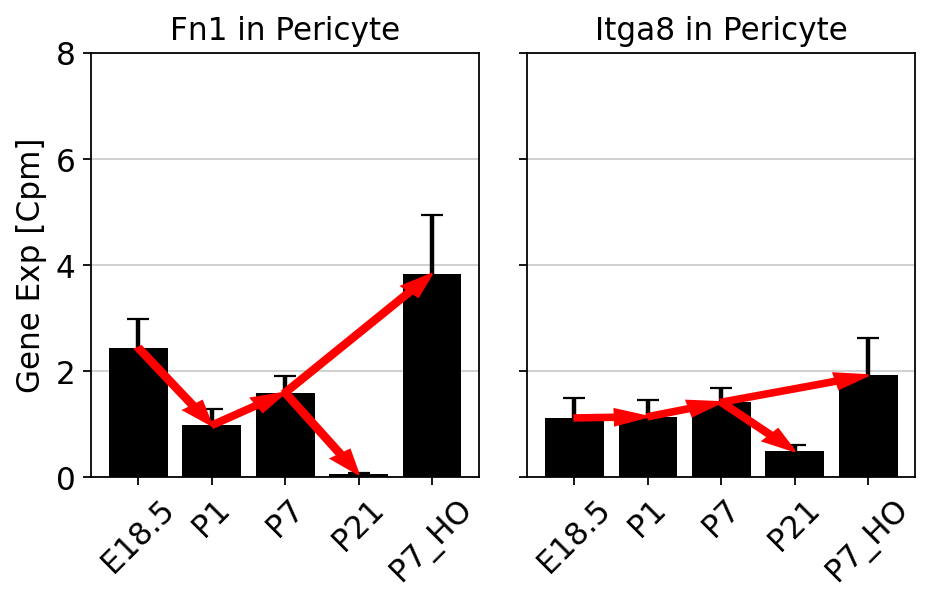

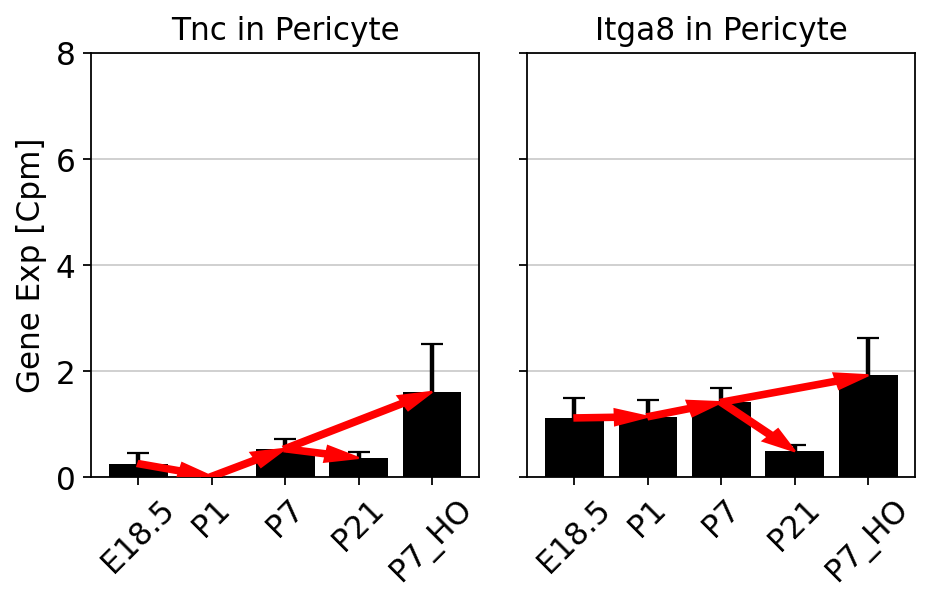

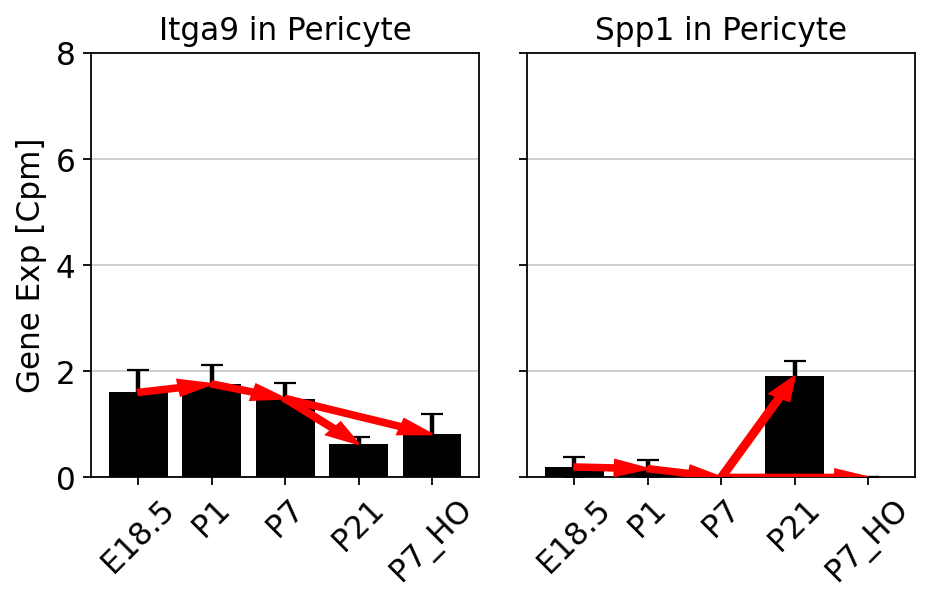

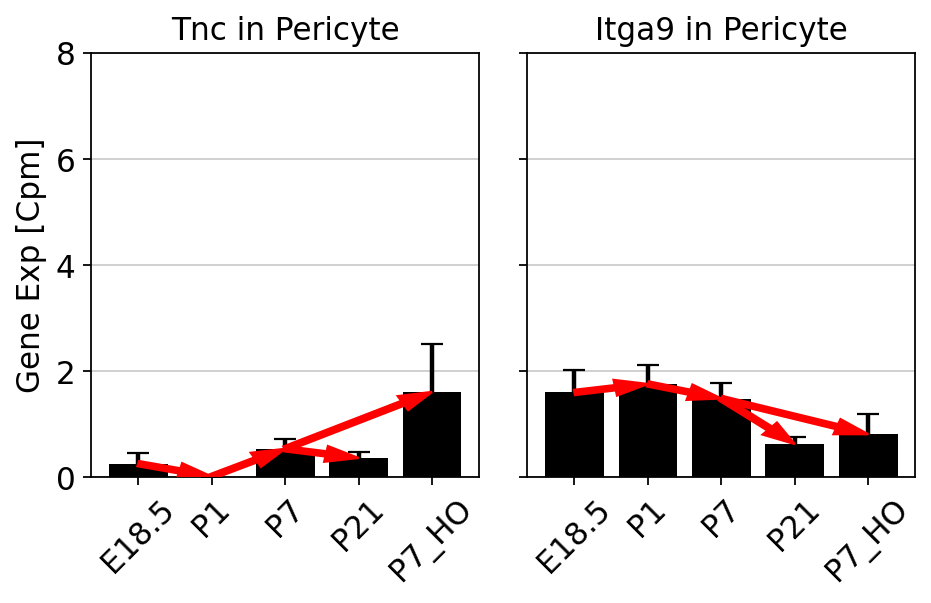

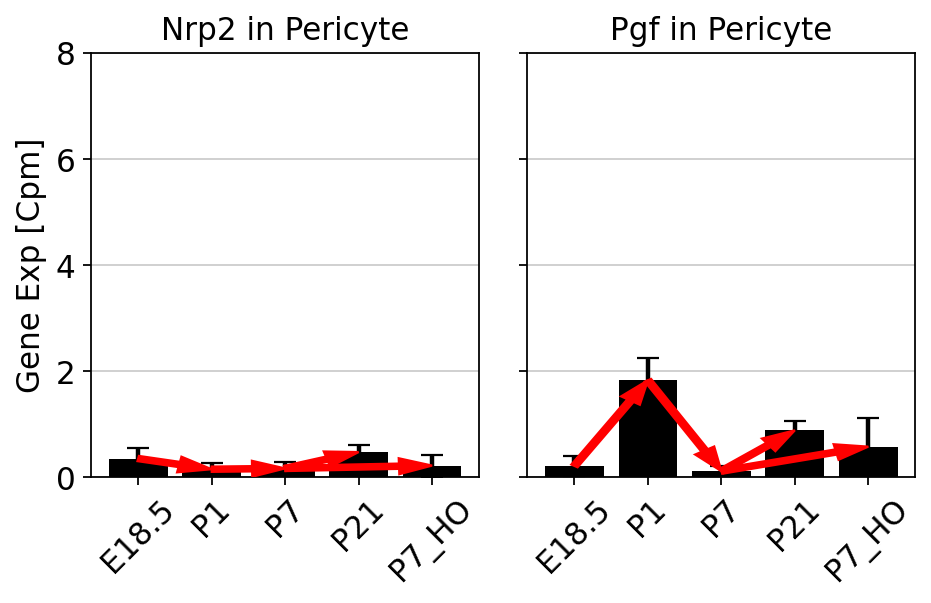

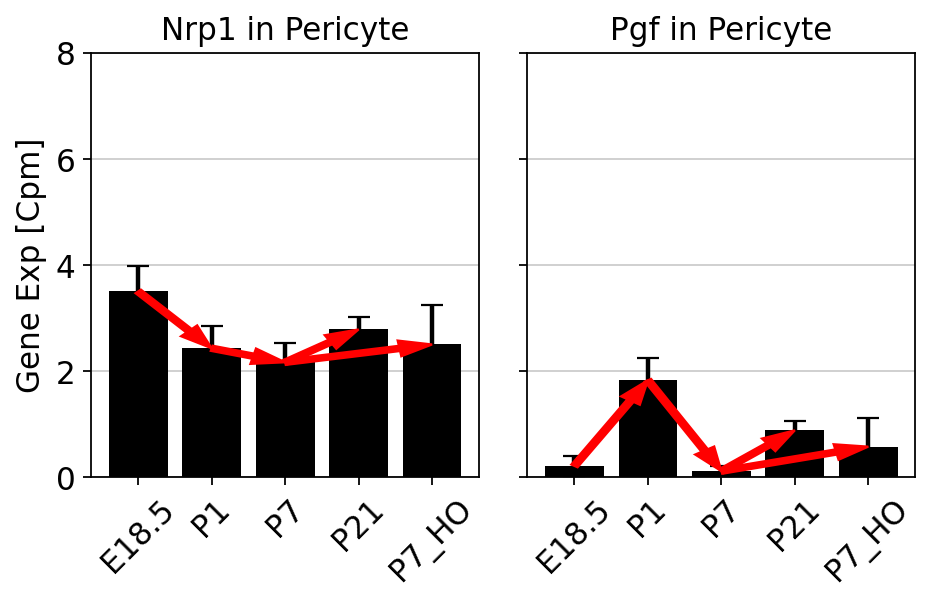

In [134]:
pairs_Car4=[['Itgb1','Col4a1'],['Itgb1','Col1a2'],['Itgb1','Col4a2'],['Itgb1','Col1a1'],
            ['Plaur','Itgb1'],['Plaur','Itga4'],['Plaur','Itgav'],
            ['Fbn1','Itgb1'],['Fbn1','Itga5'],
            ['Nectin3','Cadm1'],
            ['Itgb1','Lamc1'],
            ['Itgb1','Cspg4'],
            ['Pdgfb','Pdgfrb'],
            ['Sirpa','Cd47'],
            ['Sema7a','Itgb1']
           ]
pairs_Early_Car4=[['Col15a1','Itga1'],['Col15a1','Itgb1'],['Col18a1','Itga1'],['Col18a1','Itgb1'],
                  ['Dll1','Notch1'],['Dll1','Notch2'],['Dll1','Notch3'],['Dll1','Notch4'],
                  ['Cxcl12','Cxcr4'],
                  ['Bmp6','Bmpr2'],['Bmp6','Acvr2a'],['Bmp6','Bmpr1a'],['Bmp6','Acvr1'],['Bmp6','Acvr2b'],
                  ['Fzd6','Wnt5a'],['Fzd6','Wnt4'],['Fzd3','Wnt5a'],
                  ['Gas6','Axl'],['Il15ra','Axl'],['Il15ra','Il15'],
                  ['Clcf1','Il6st'],['Clcf1','Lifr']
                 ]
pairs_pericyte=[['Cadm1','Cadm1'],
                ['Cd44','Hbegf'],['Cd44','Hgf'],['Cd44','Spp1'],
                ['Wnt5a','Fzd1'],['Wnt4','Fzd1'],
                ['Bmpr1a','Bmp2'],['Bmpr1a','Bmp4'],['Bmpr1a','Bmp5'],
                ['Wnt5a','Ror1'],['Wnt4','Smo'],['Bmp2','Smo'],
                ['Fn1','Itga8'],['Tnc','Itga8'],
                ['Itga9','Spp1'],['Tnc','Itga9'],
                ['Nrp2','Pgf'],['Nrp1','Pgf']
               ]

pairs_cts=[['Car4+ capillaries','Pericyte'],['Early Car4- capillaries','Pericyte'],['Pericyte','Pericyte']]
pairs_dic={'Car4+ capillaries':pairs_Car4,'Early Car4- capillaries':pairs_Early_Car4,'Pericyte':pairs_pericyte}
adata_dic={
            'Pericyte':[
                    adata_d[('Pericyte','E18.5')],
                    adata_d[('Pericyte','P1')],
                    adata_d[('Pericyte','P7')],
                    adata_d[('Pericyte','P21')],
                    adata_d[('Pericyte','P7_HO')]
                        ],
           'Car4+ capillaries':[
                    adata_d[('Car4+ capillaries','E18.5')],
                    adata_d[('Car4+ capillaries','P1')],
                    adata_d[('Car4+ capillaries','P7')],
                    adata_d[('Car4+ capillaries','P21')],
                    adata_d[('Car4+ capillaries','P7_HO')]
                       ],
           'Early Car4- capillaries':[
                    adata_d[('Car4- capillaries','E18.5')],
                    adata_d[('Car4- capillaries','P1')],
                    adata_d[('Car4- capillaries','P7')],
                    adata_d[('Car4- capillaries','P21')],
                    adata_d[('Car4- capillaries','P7_HO')]
                       ]
          }

timepoint=['E18.5','P1','P7','P21','P7_HO']
y_gene_ct=[{},{}] #为了使用for循环产生y_gene1_ct1(y_gene_ct[0])和y_gene2_ct2(y_gene_ct[1])

for ct in pairs_cts: #ct is a list,ct[0]=ct1,ct[1]=ct2
    pairs=pairs_dic[ct[0]]
    for gene in pairs:
        fig,axs=plt.subplots(1,2,figsize=(6,4),sharey=True)#sharey=True一横排共享一个y轴
        for k,(gene_k,ct_k) in enumerate(zip(gene,ct)): #k代表的是数字，y_gene_ct[k]是dic，对应的key是（gene，ct）
            y_gene_ct[k][(gene_k,ct_k)]=[]
            x=[0,1,2,3,4]
            y=[]
            sem_gene_ct=[]
            x_arrow=[0,1,2,3,4]
            y_arrow=[] 
            #for loop添加元素之前先定义empty list
            for j,tp in enumerate(timepoint):
                gene_ct=adata_dic[ct_k][j][:,gene_k].X.toarray()[:,0]
                y_gene_ct[k][(gene_k,ct_k)].append(gene_ct)
                y.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
                sem_gene_ct.append((y_gene_ct[k][(gene_k,ct_k)][j]).std()/np.sqrt((y_gene_ct[k][(gene_k,ct_k)][j]).size))
                y_arrow.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
                
            ax=axs[k]
            ax=sns.barplot(x,y,label='_nolegend_',lw=2,ax=ax,color='black',zorder=10) 
            # label='_nolegend_'，legend没有这个图的；zorder把grid隐到后面
            ax.errorbar(x,y,yerr=sem_gene_ct,color='black',ls='',capsize=5,label='sem',lw=2)
            ax.set_title(gene_k+' in '+ct_k)
            ax.set_ylim(0,8)
            ax.set_xticklabels(['E18.5','P1','P7','P21','P7_HO'],rotation=45)
            for a in range(3): #E18.5-P1,P1-P7,P7-P21的箭头
                ax.arrow(x_arrow[a],y_arrow[a],x_arrow[a+1]-x_arrow[a],y_arrow[a+1]-y_arrow[a],length_includes_head=True,color='red',zorder=10,width=0.1)
            ax.arrow(x_arrow[2],y_arrow[2],x_arrow[4]-x_arrow[2],y_arrow[4]-y_arrow[2],length_includes_head=True,color='red',zorder=10,width=0.1) 
            # P7和P7_HO的箭头
            if k==0:
                ax.set_ylabel('Gene Exp [Cpm]') 
                #设置左图的label
        plt.tight_layout()
        plt.subplots_adjust(left=0.1)
        #fig.savefig('figures/interaction_endo_peri/timepoint/'+gene[0]+' in '+ct[0]+' & '+gene[1]+' in '+ct[1]+'_timepoint.png')

<ipython-input-134-2f2a2ce8d62a>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs=plt.subplots(1,2,figsize=(6,4),sharey=True)#sharey=True一横排共享一个y轴


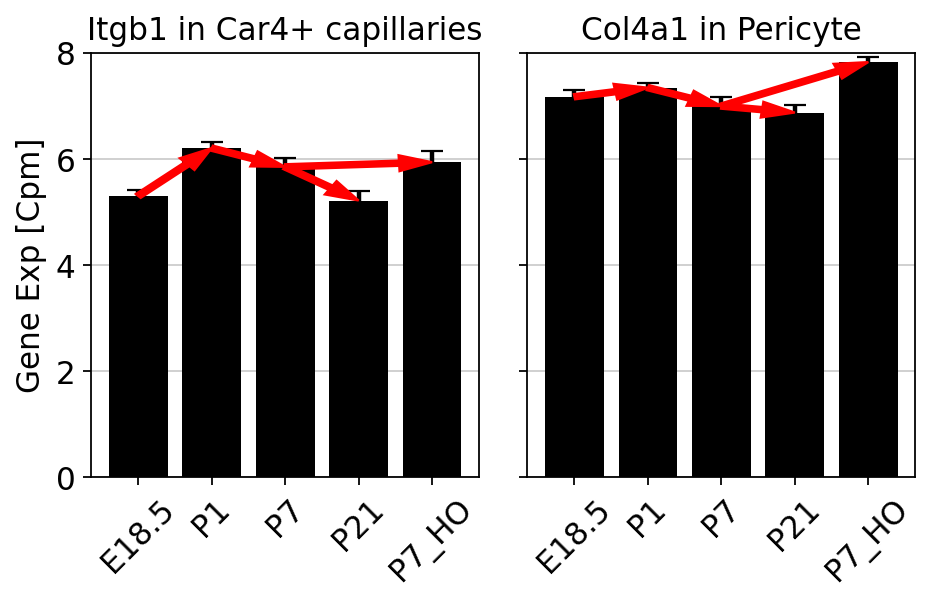

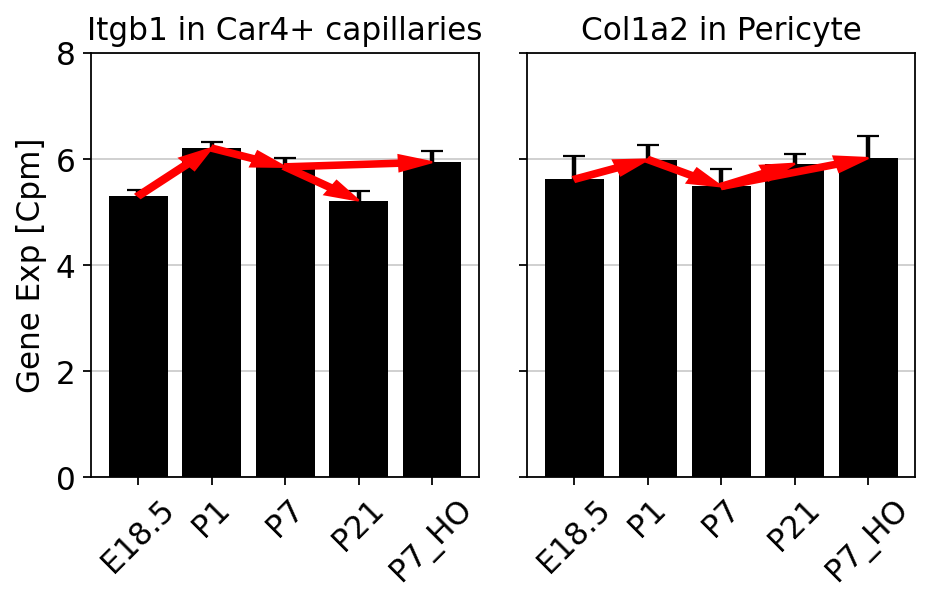

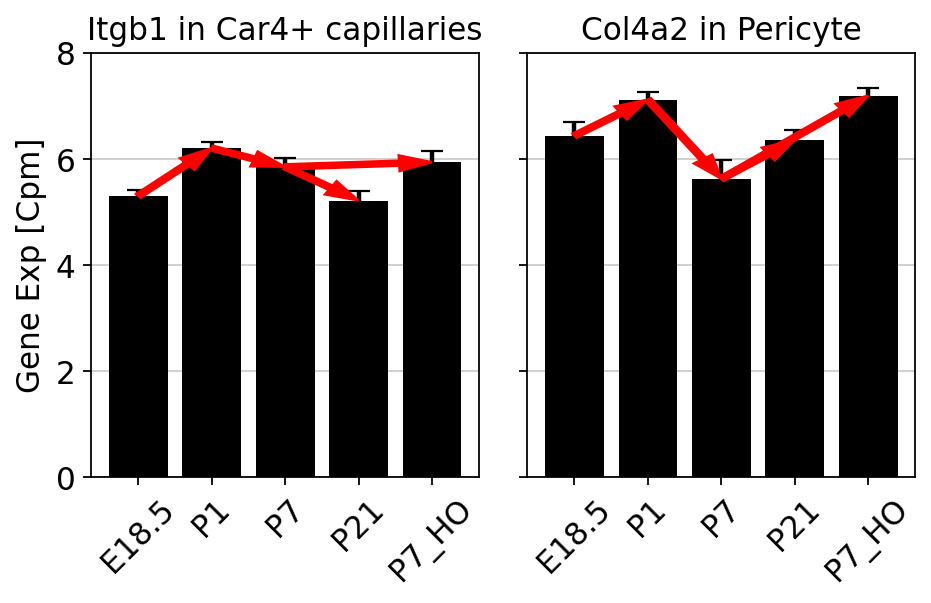

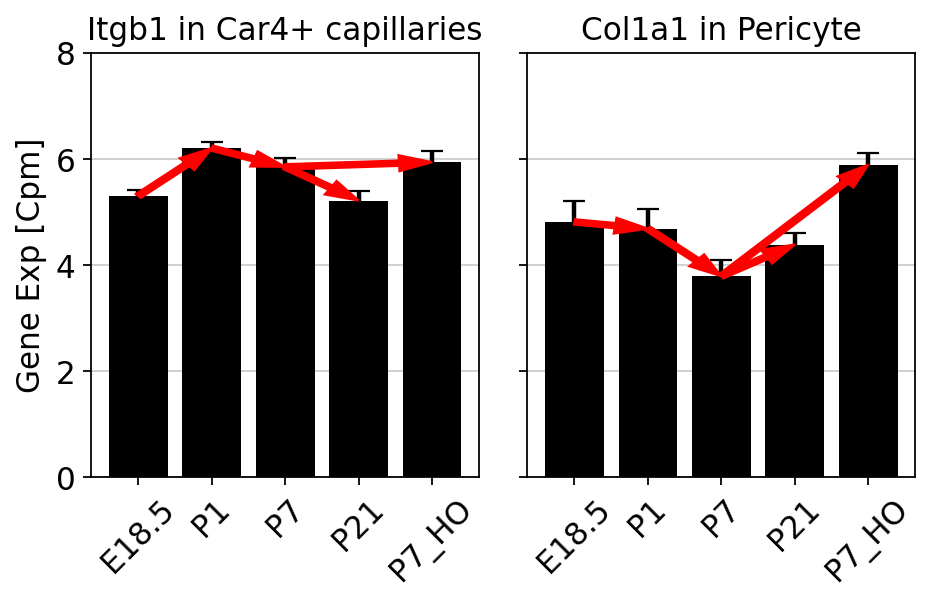

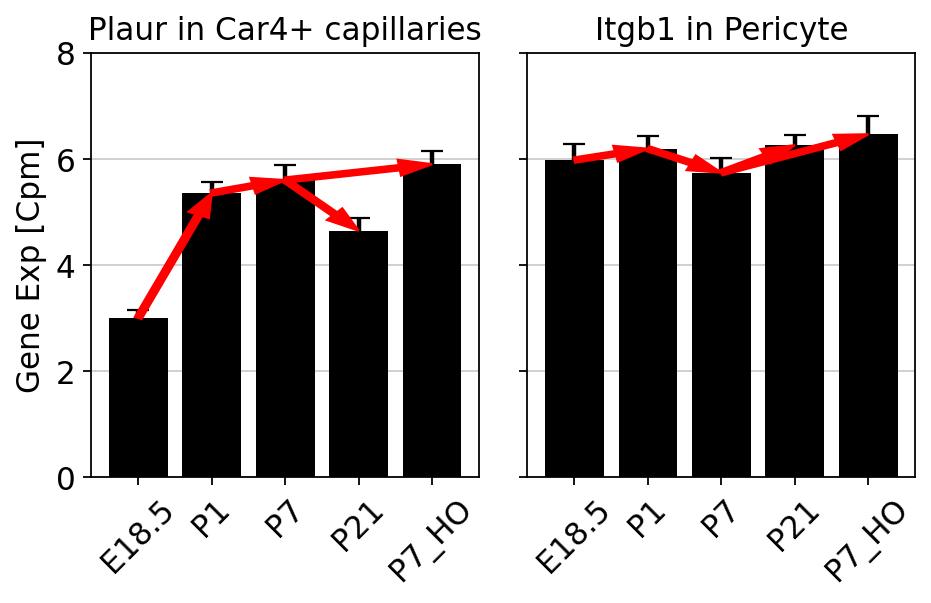

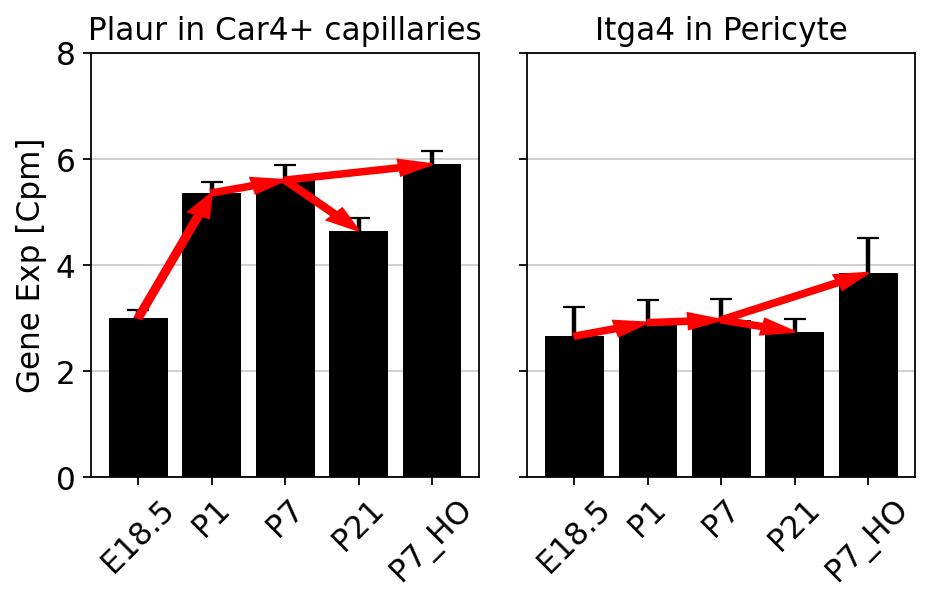

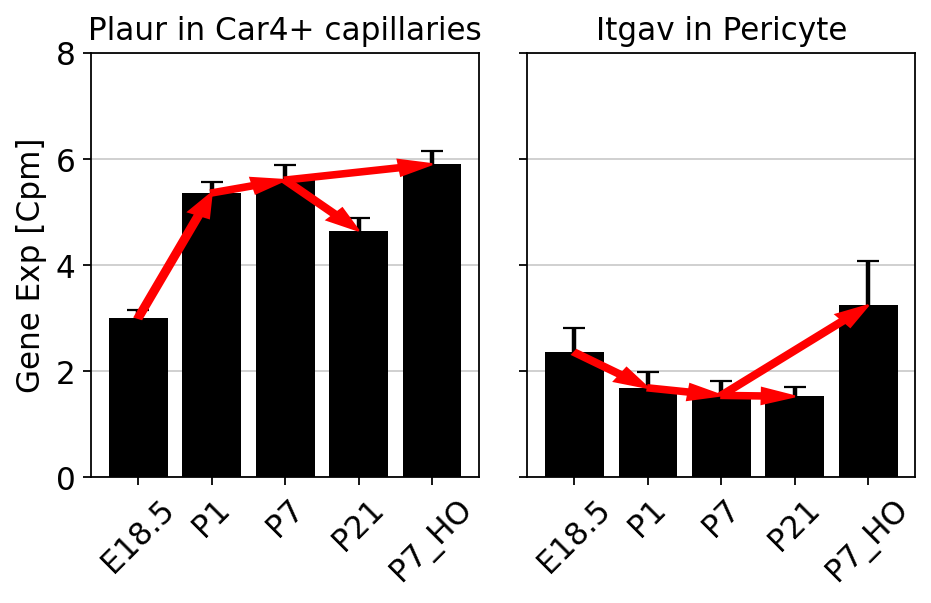

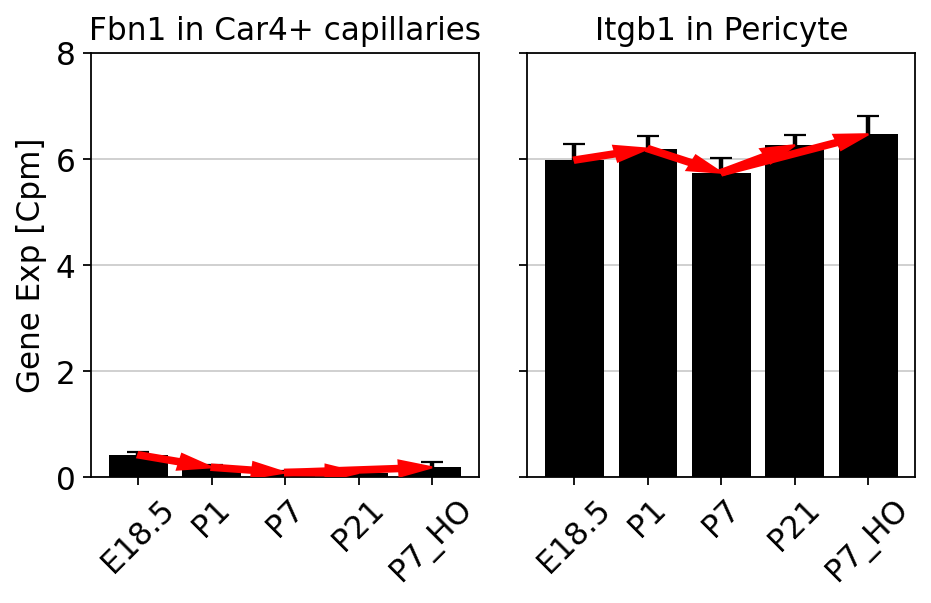

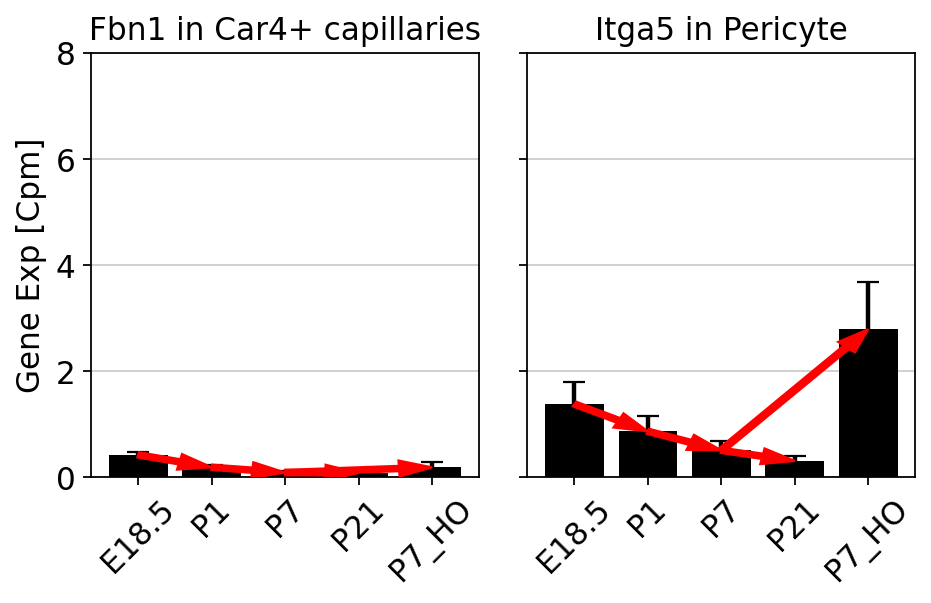

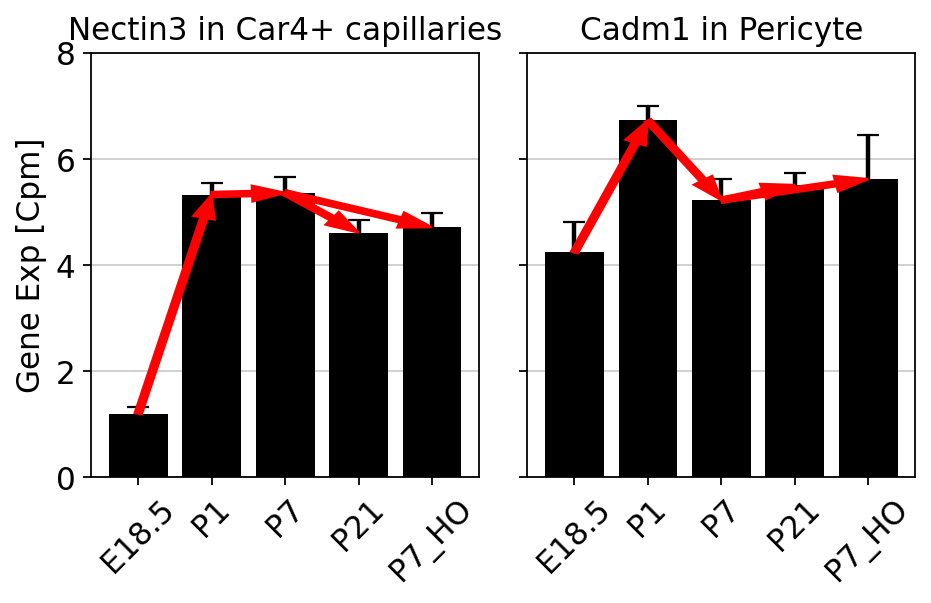

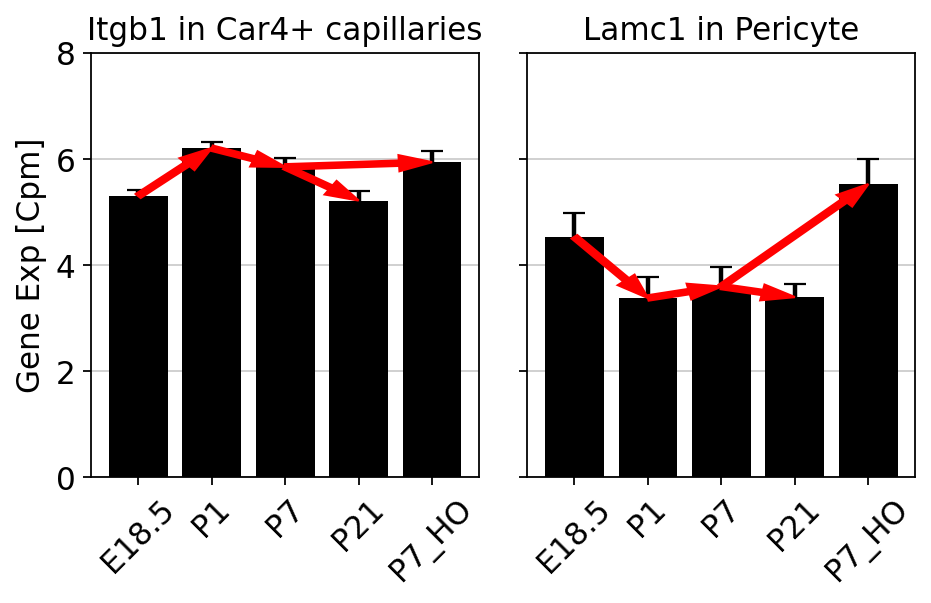

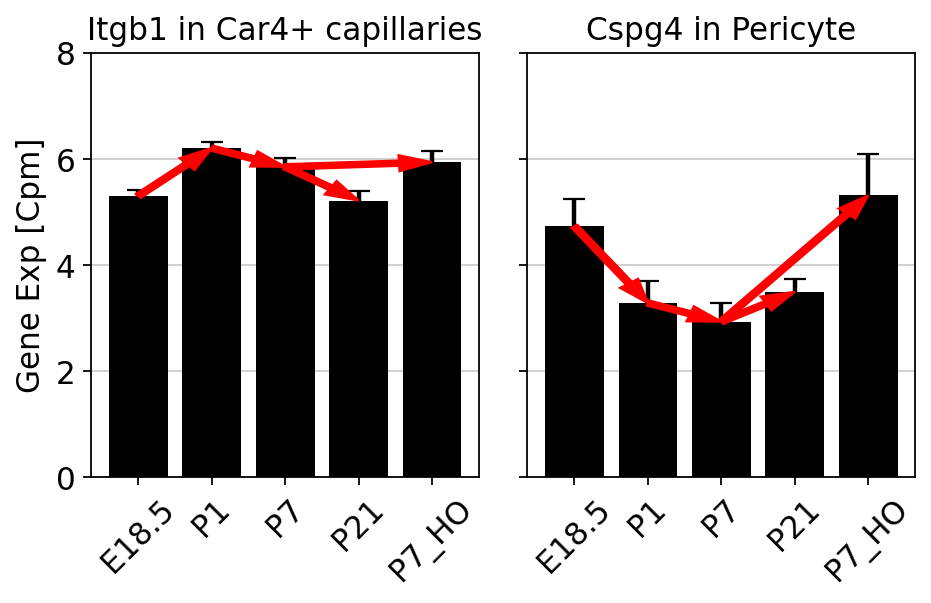

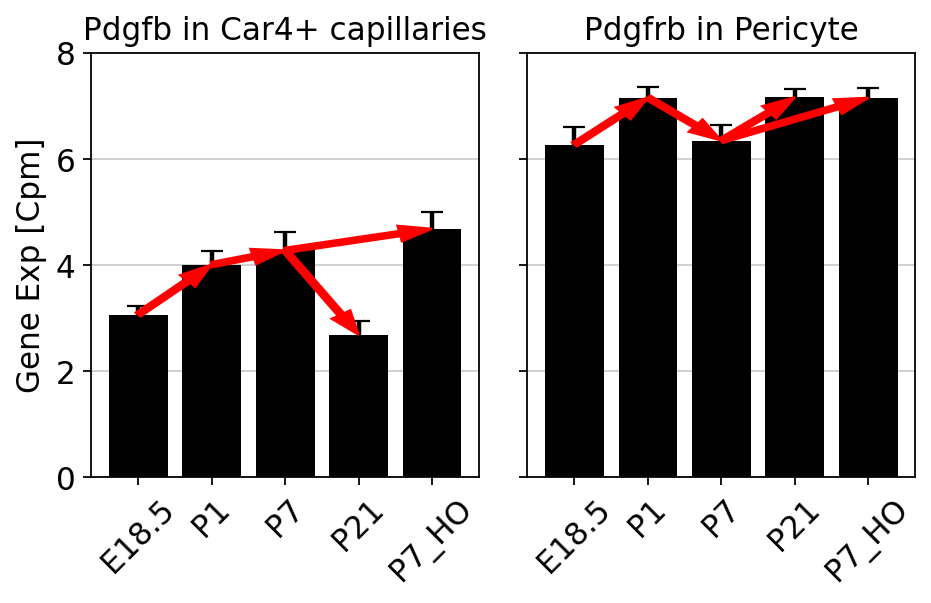

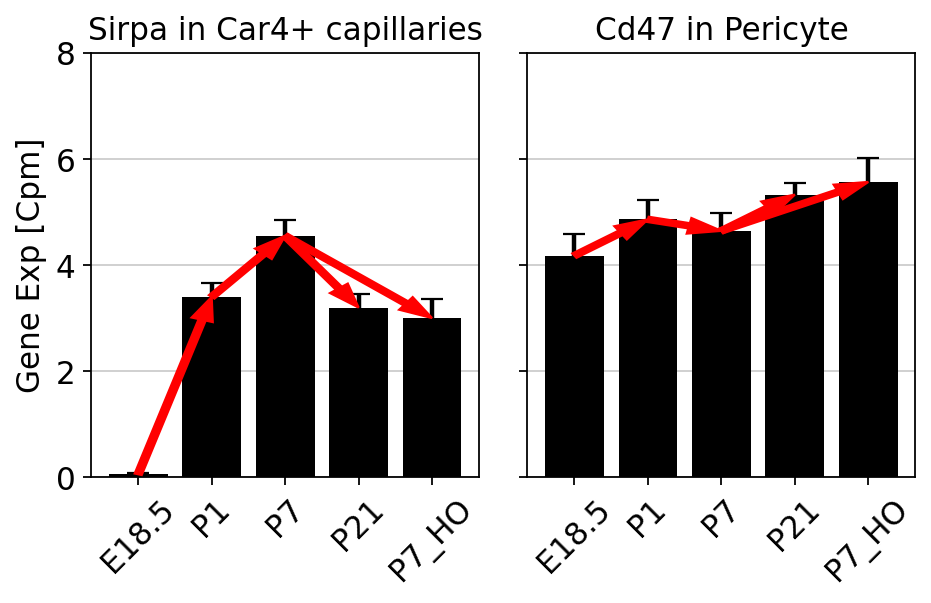

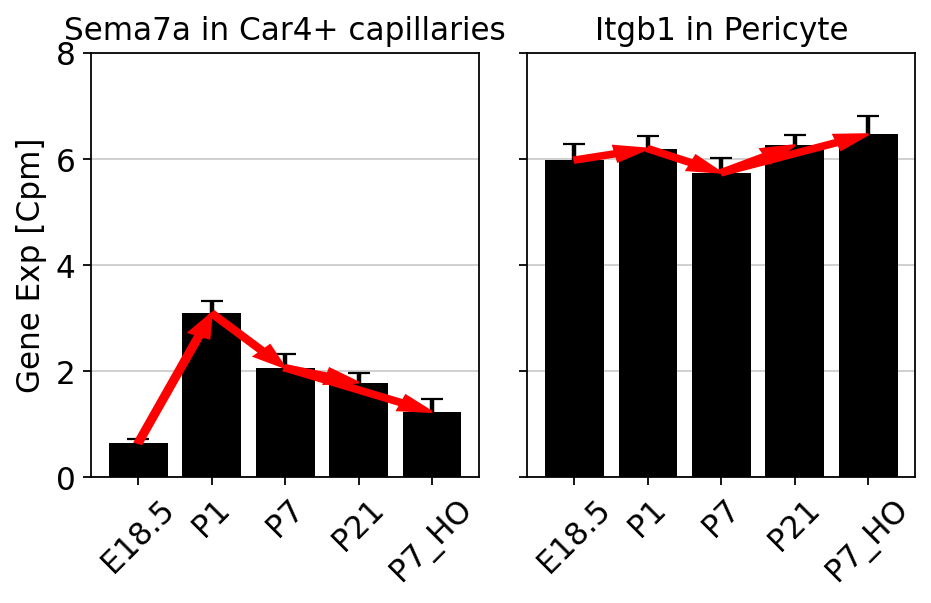

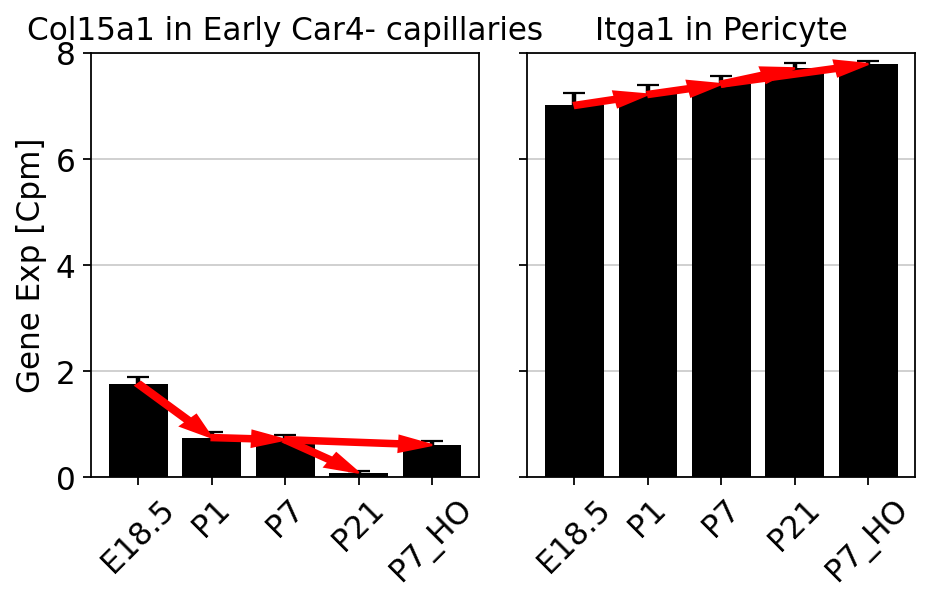

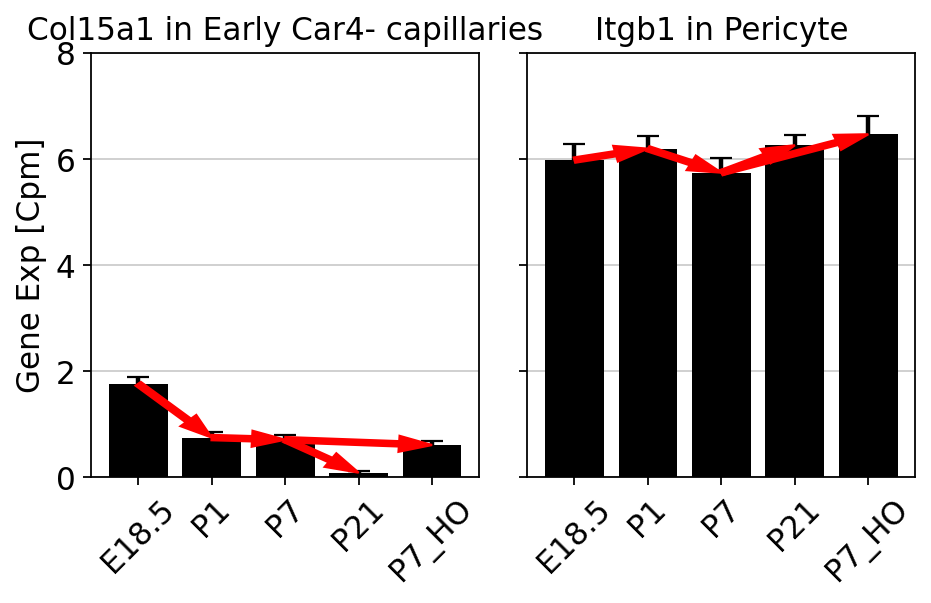

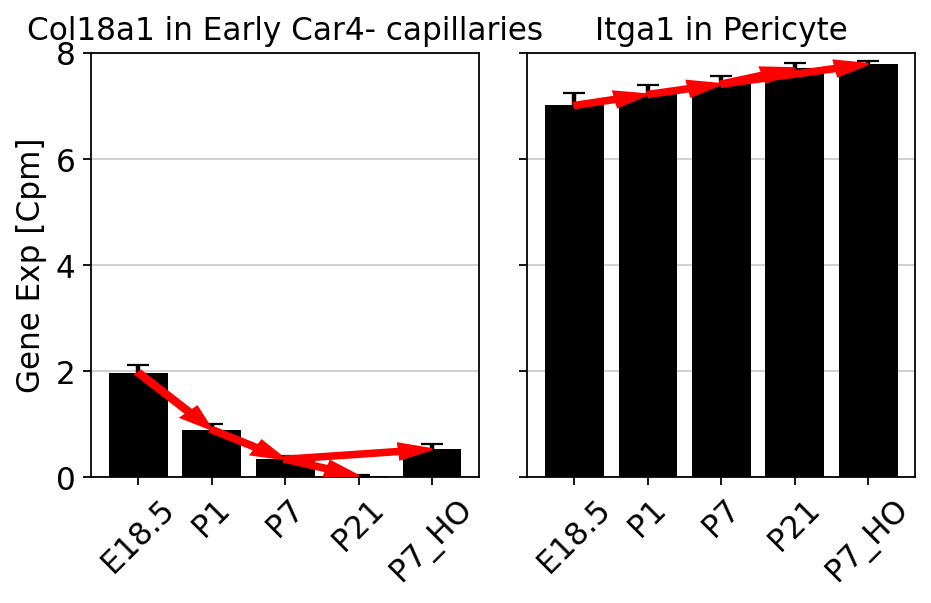

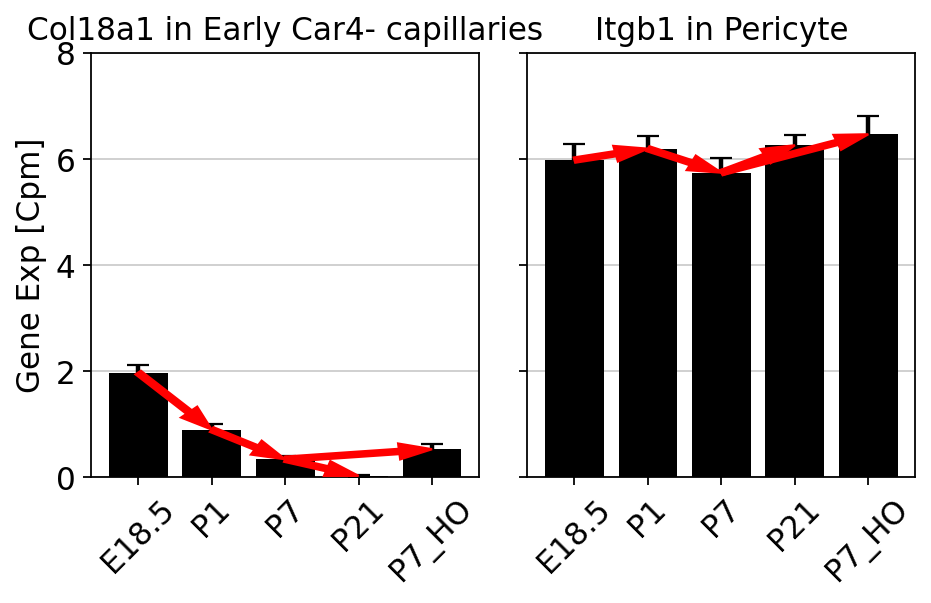

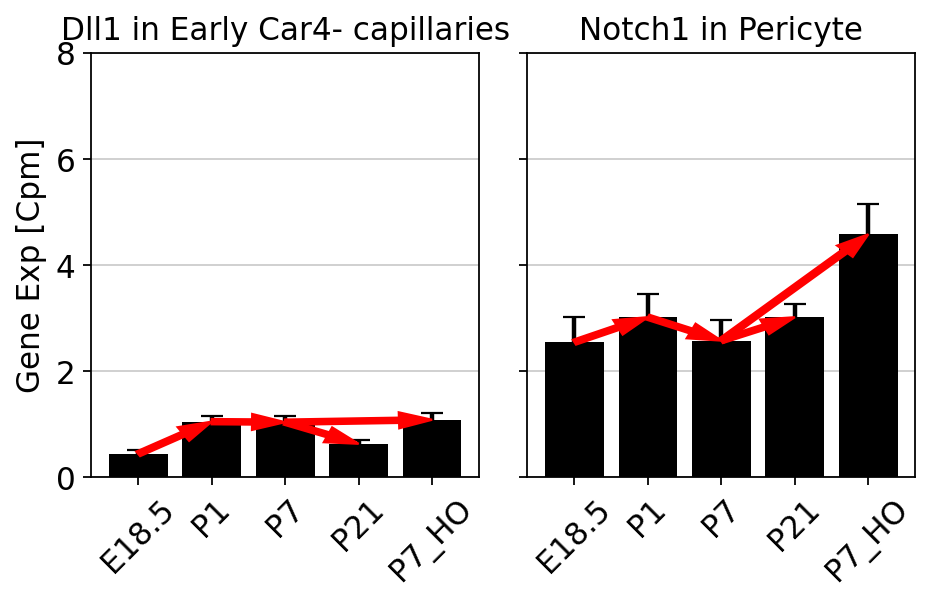

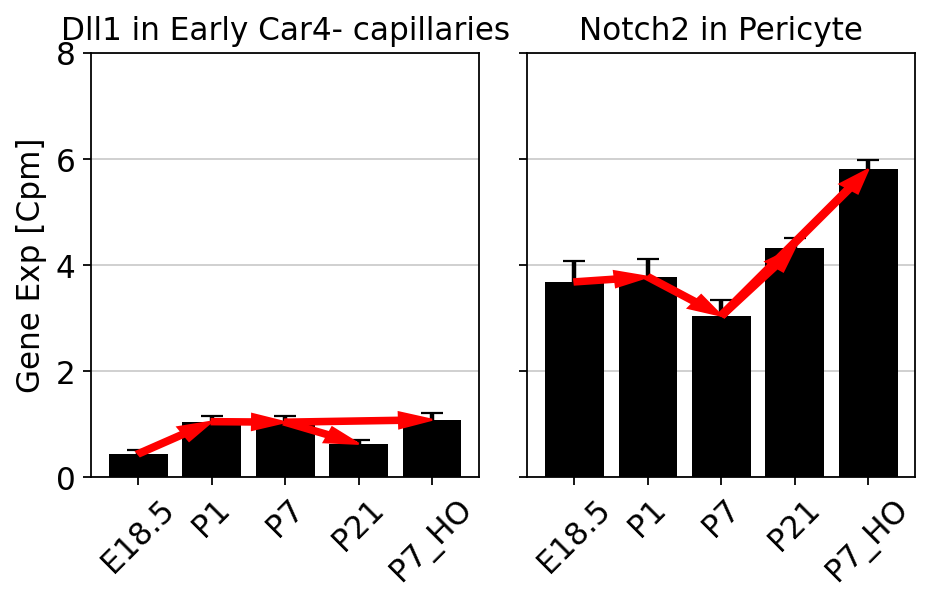

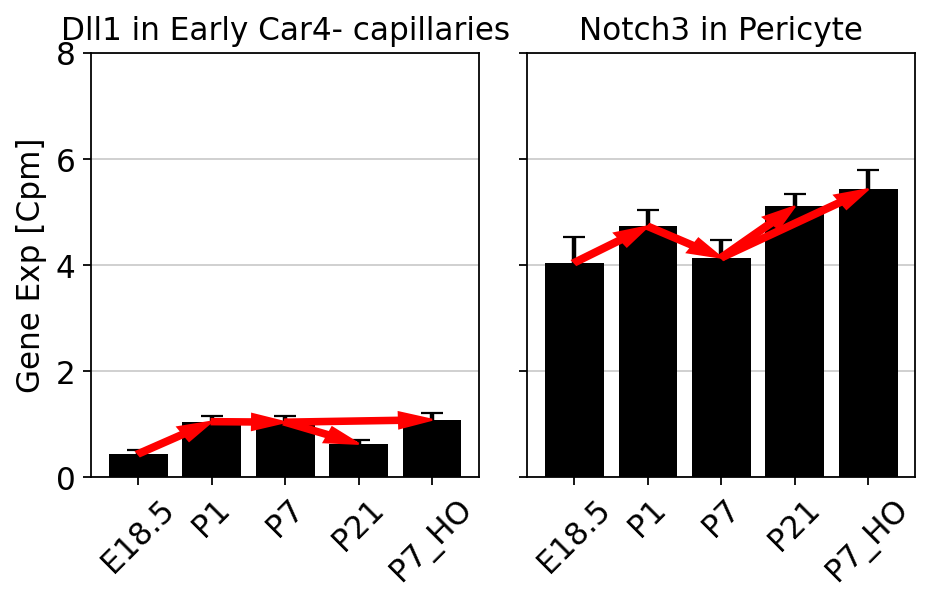

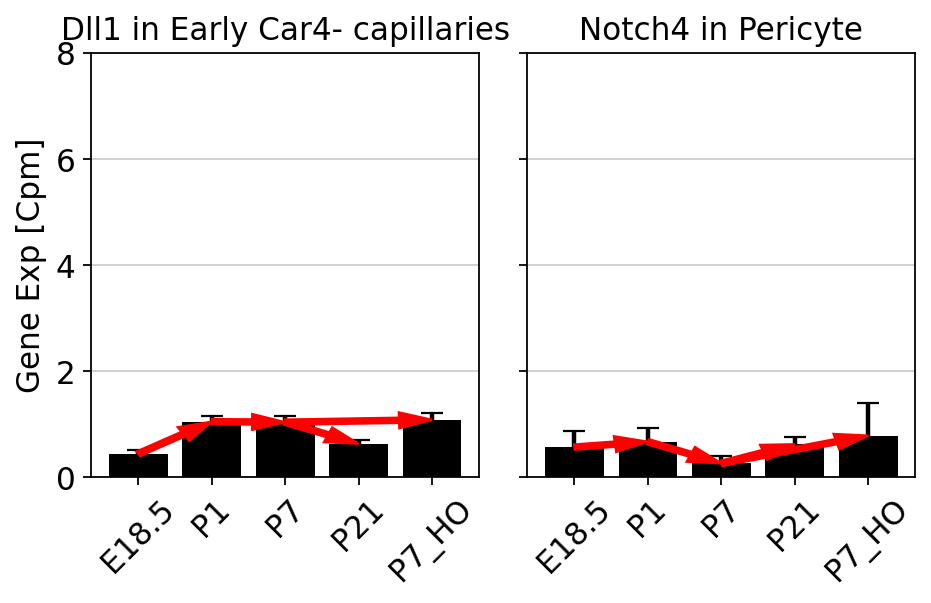

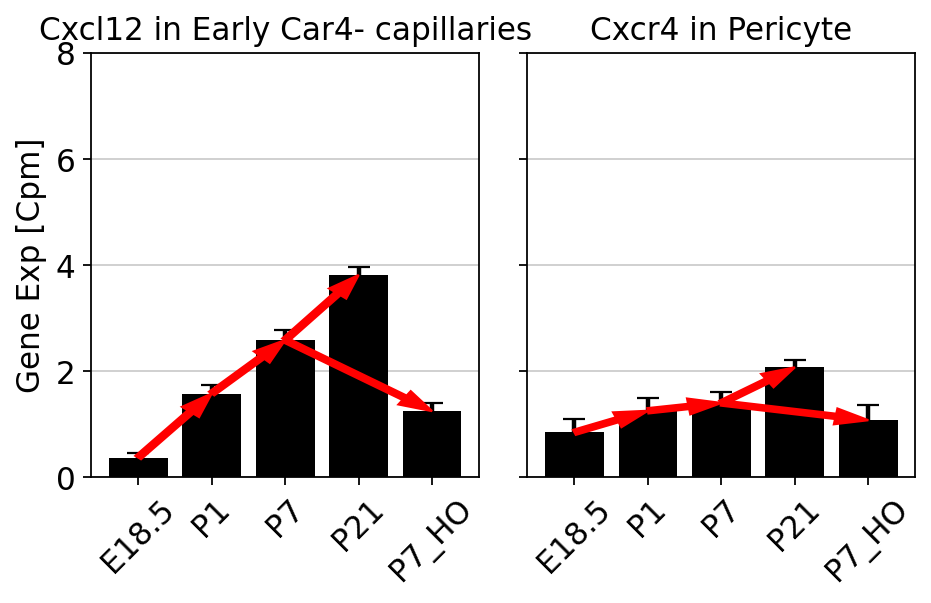

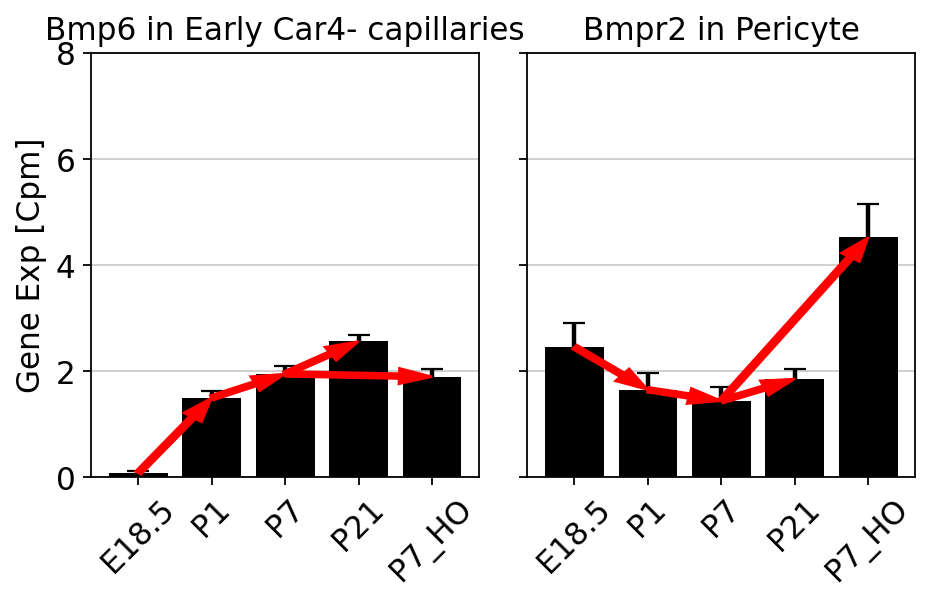

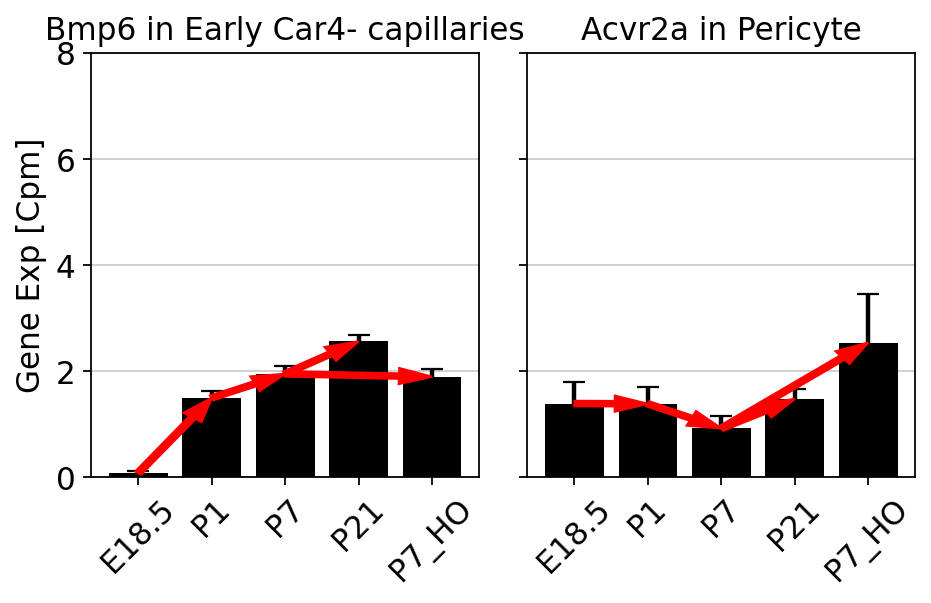

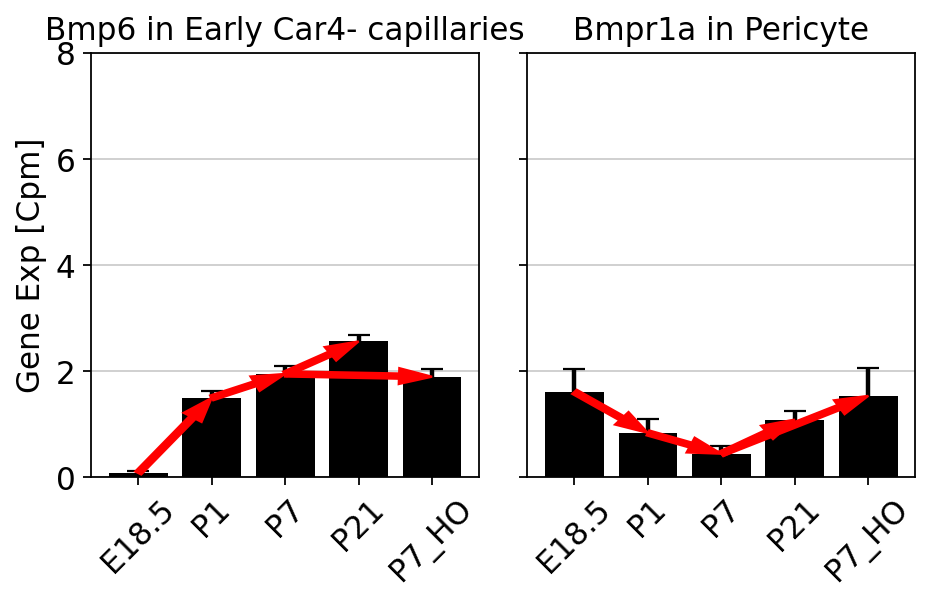

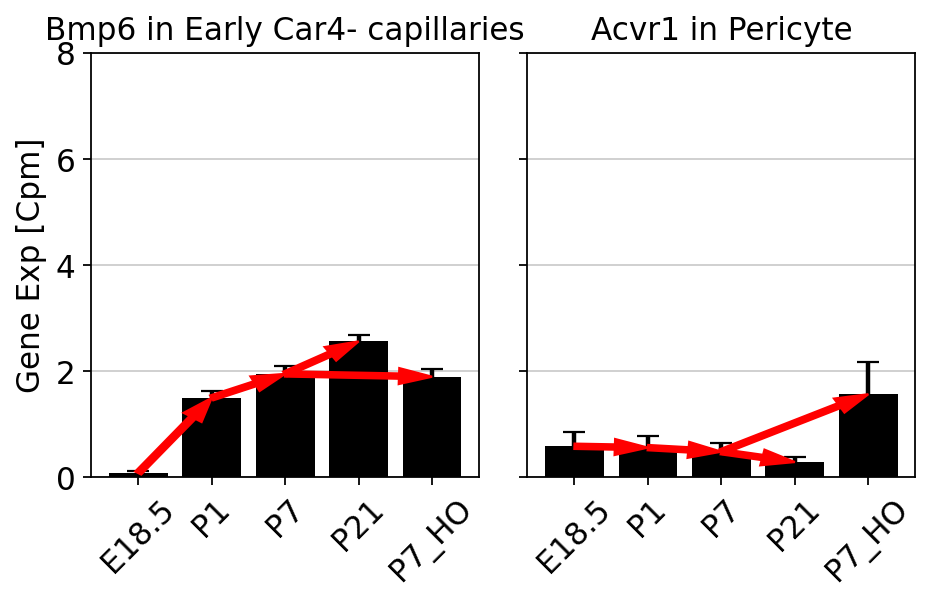

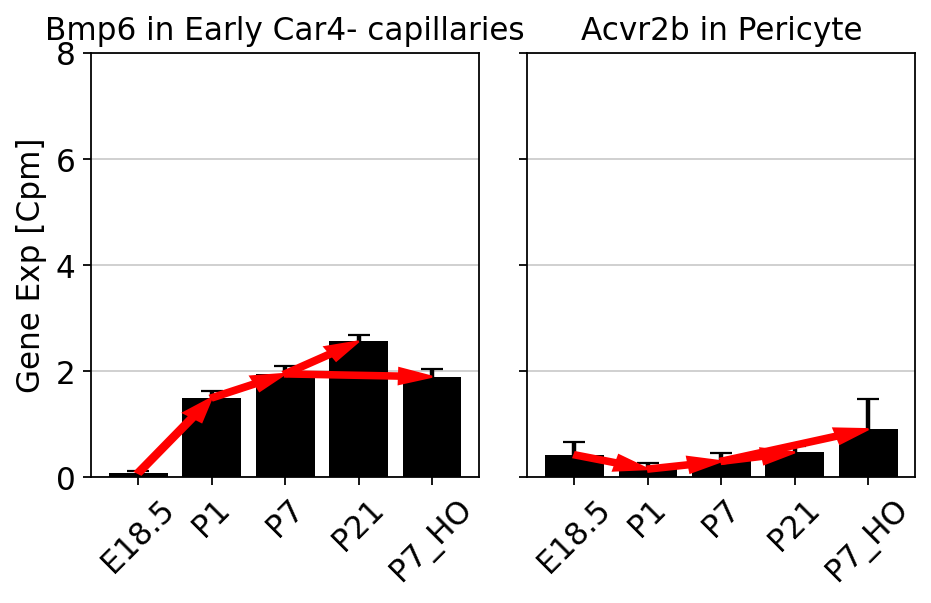

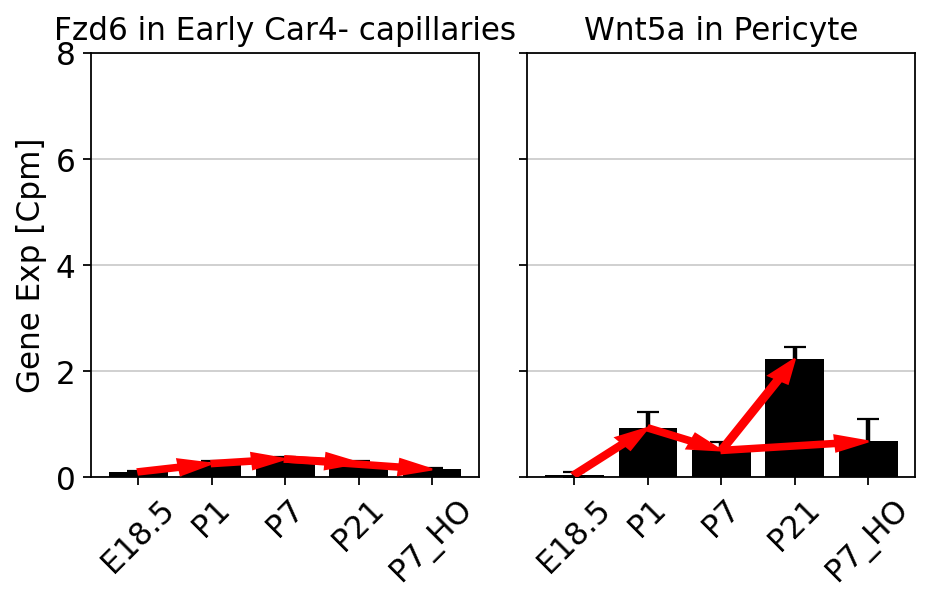

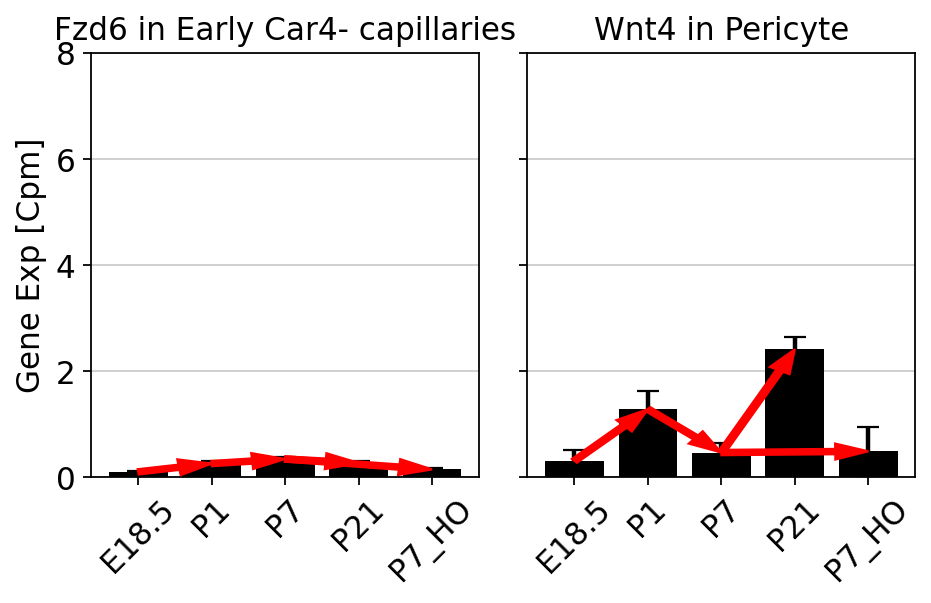

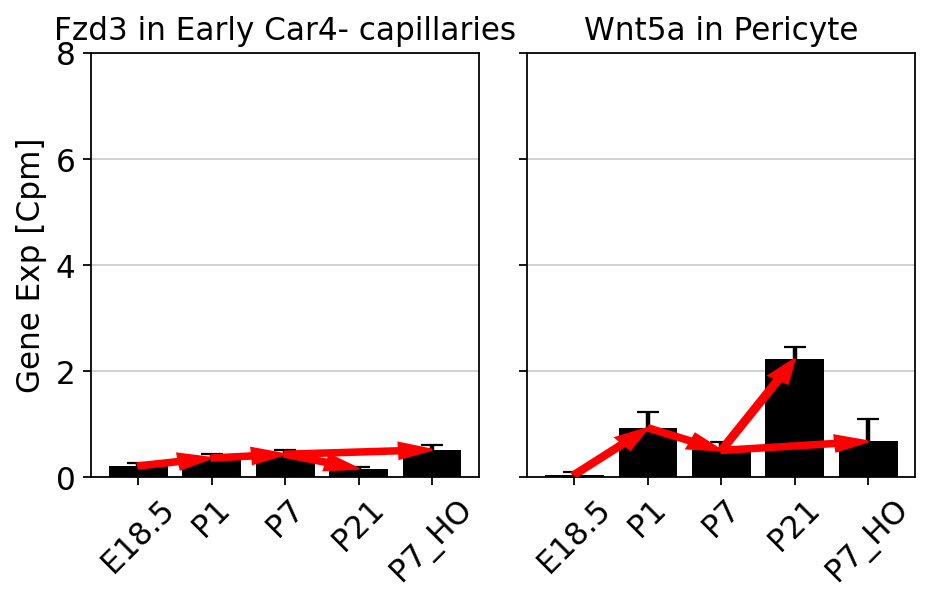

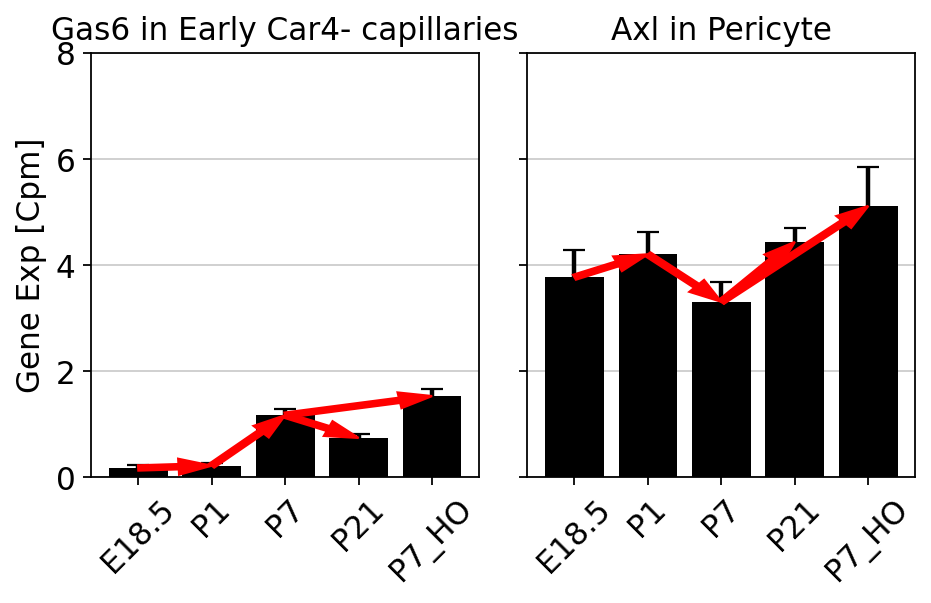

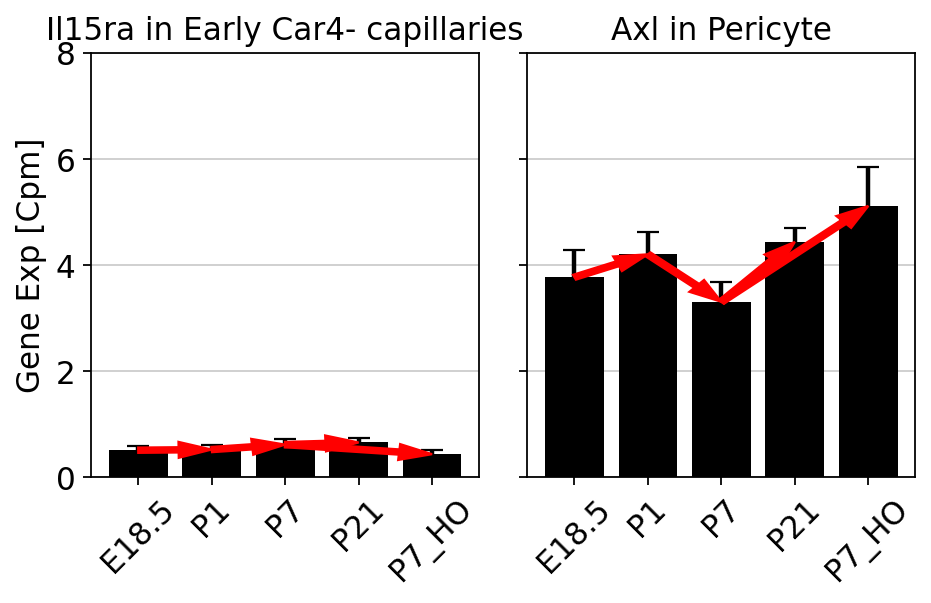

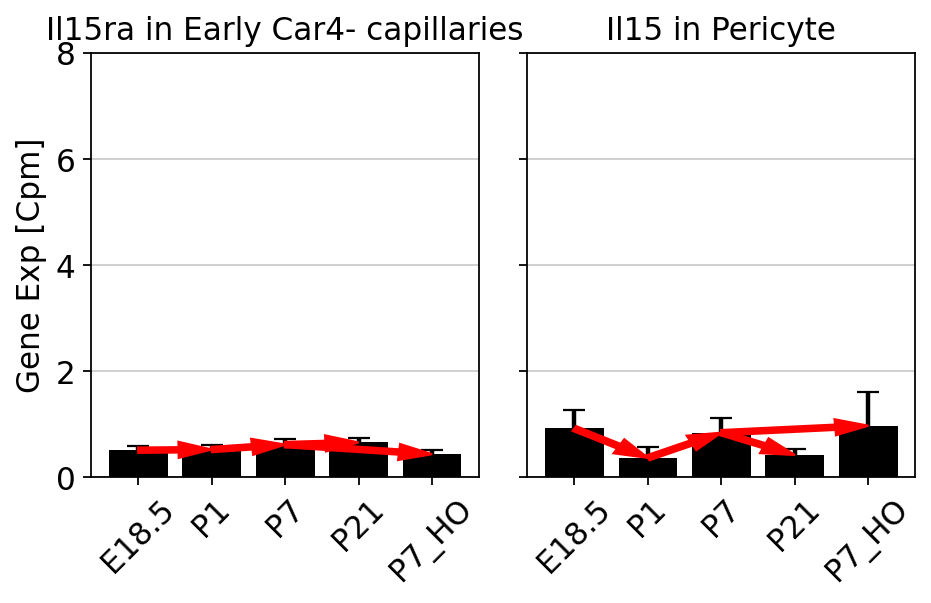

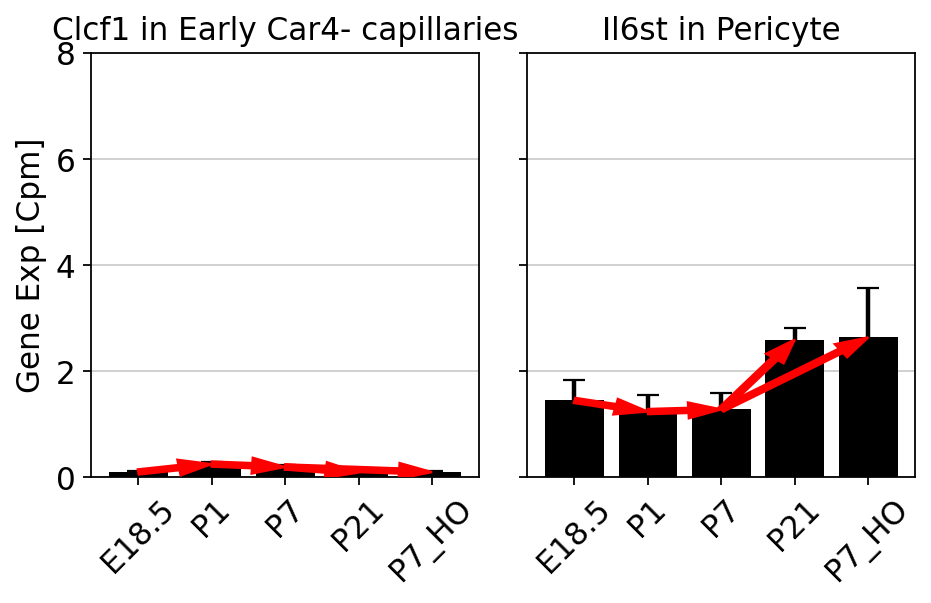

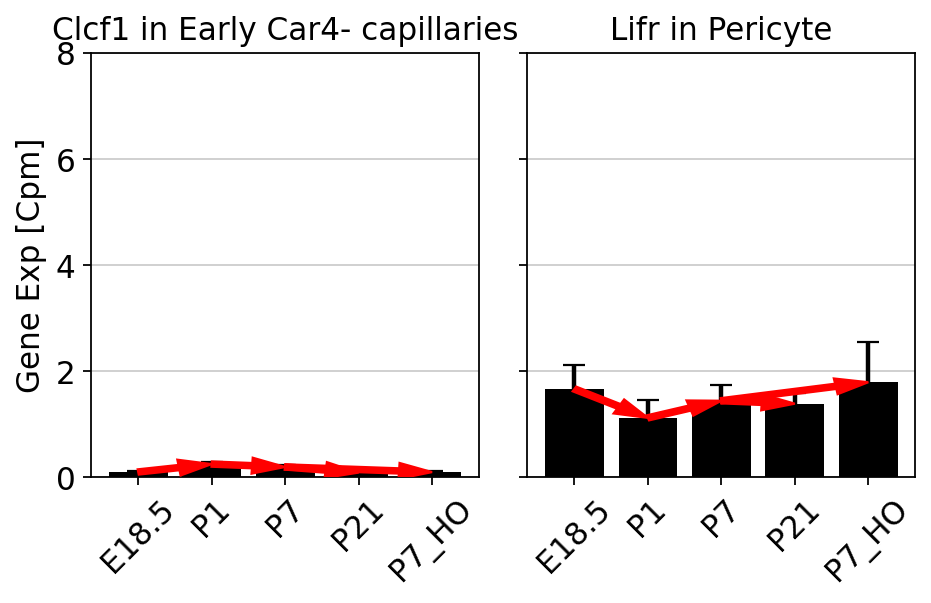

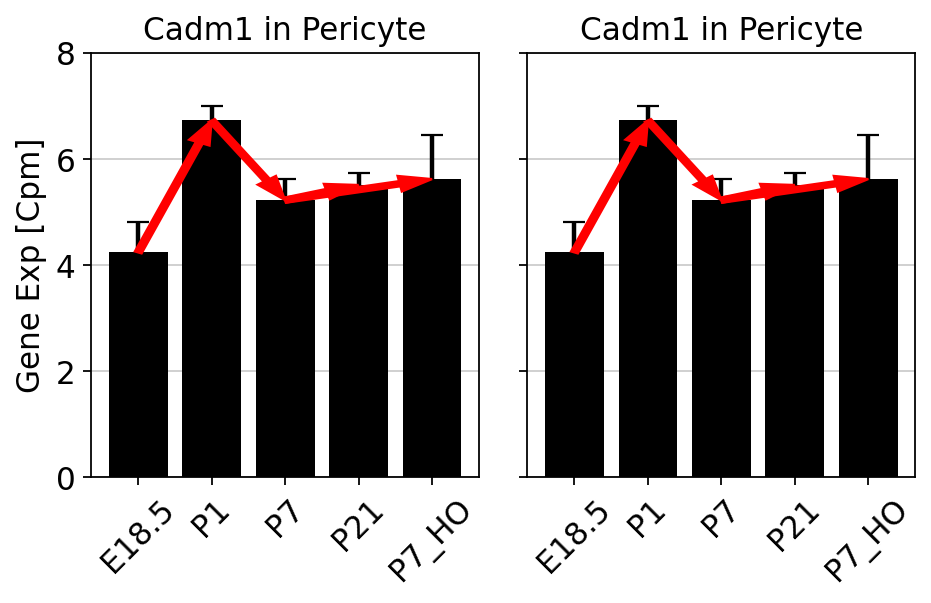

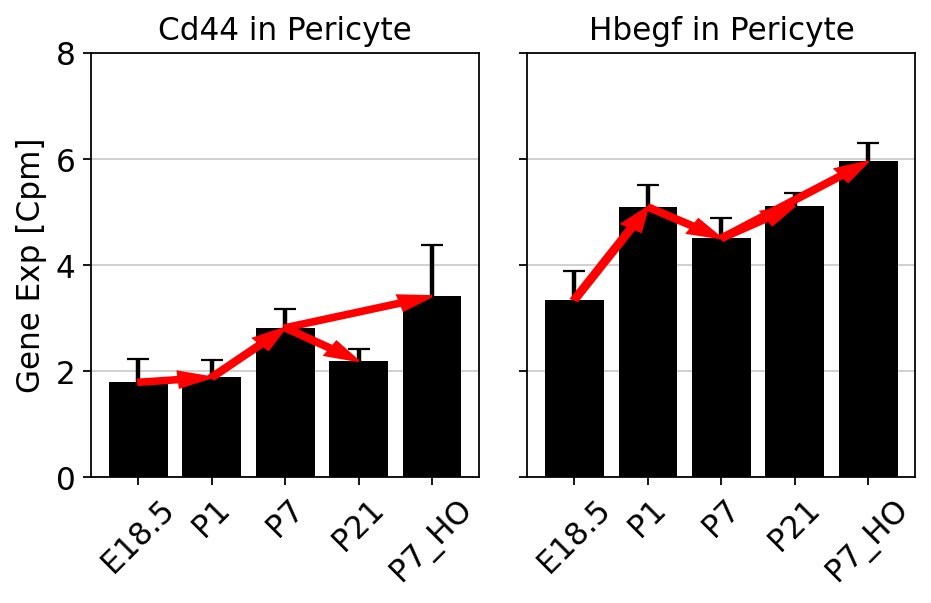

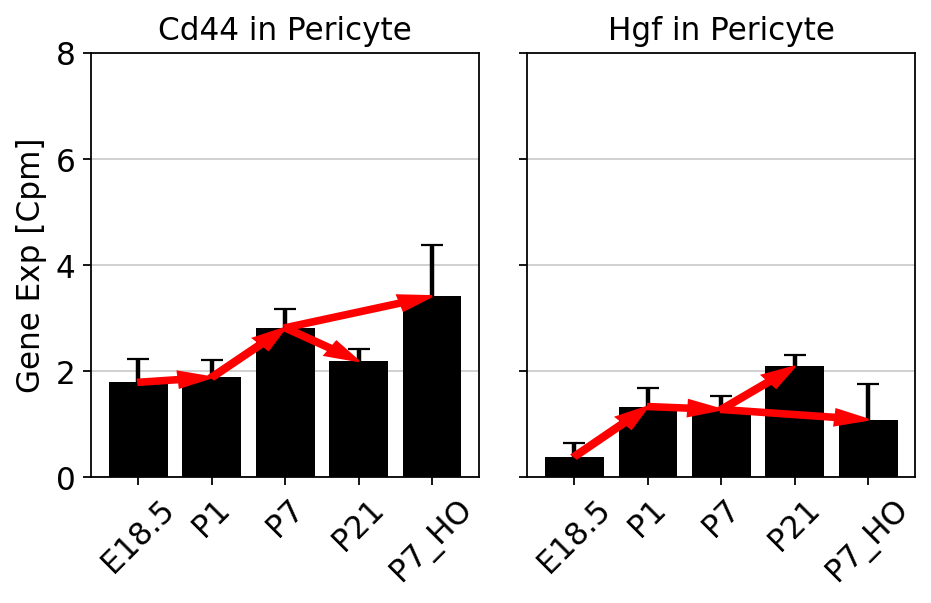

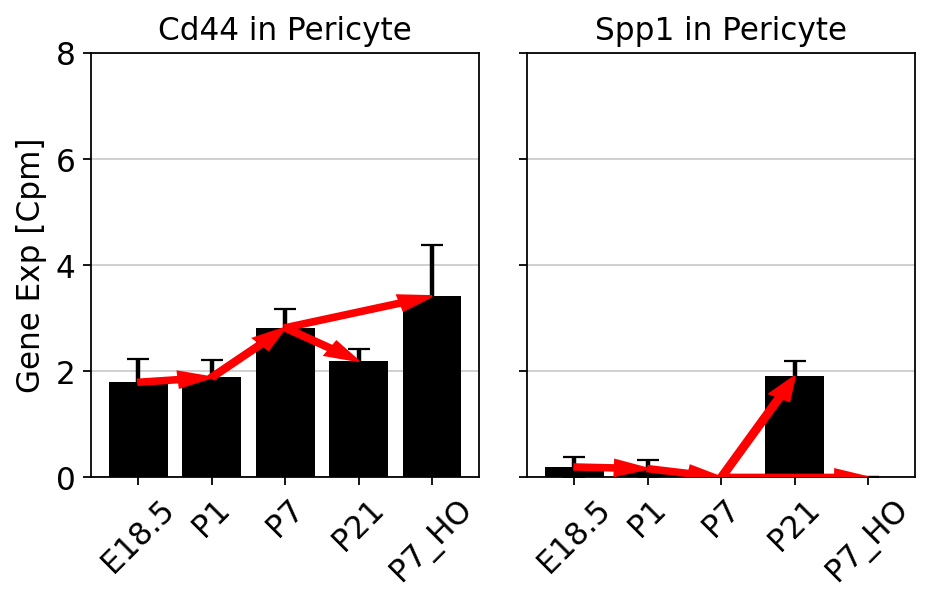

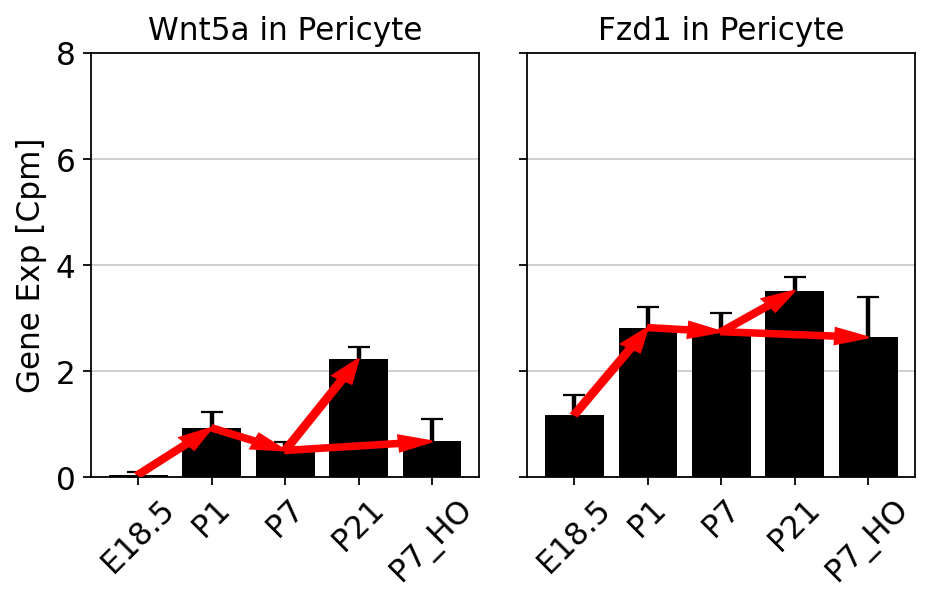

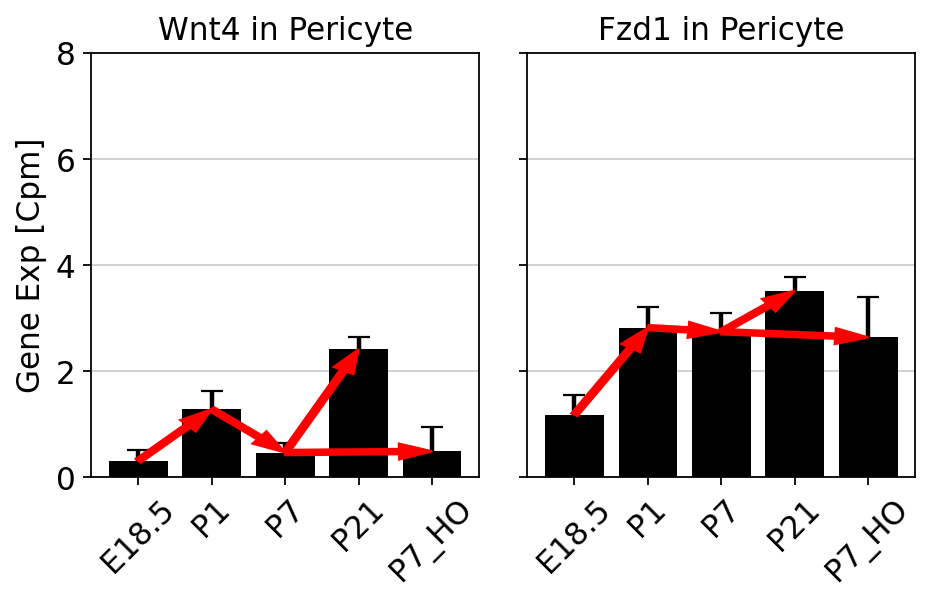

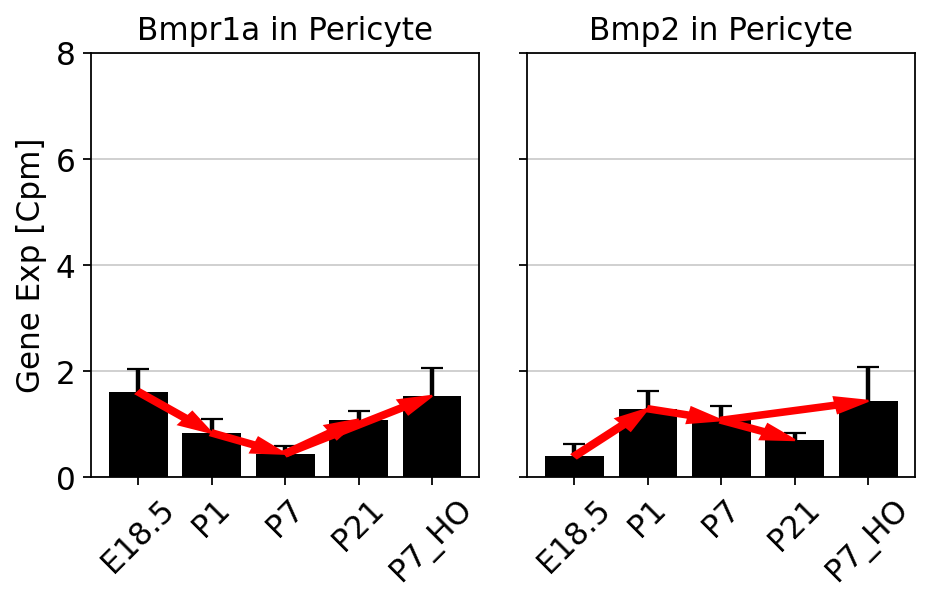

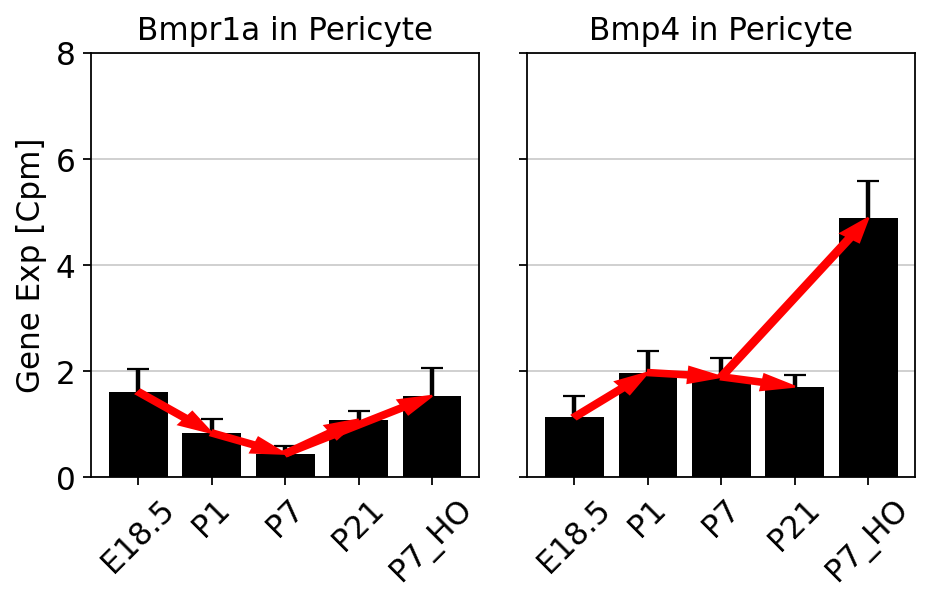

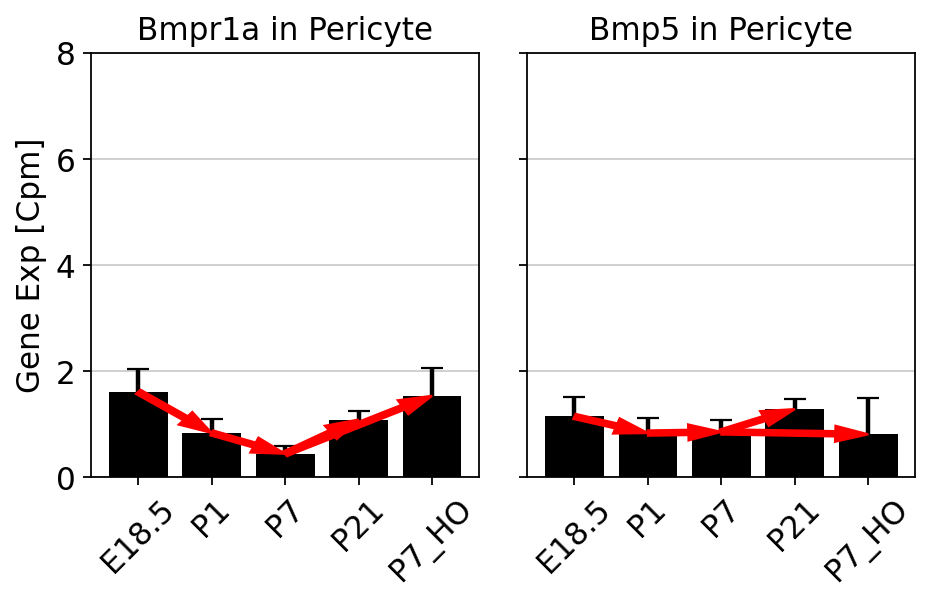

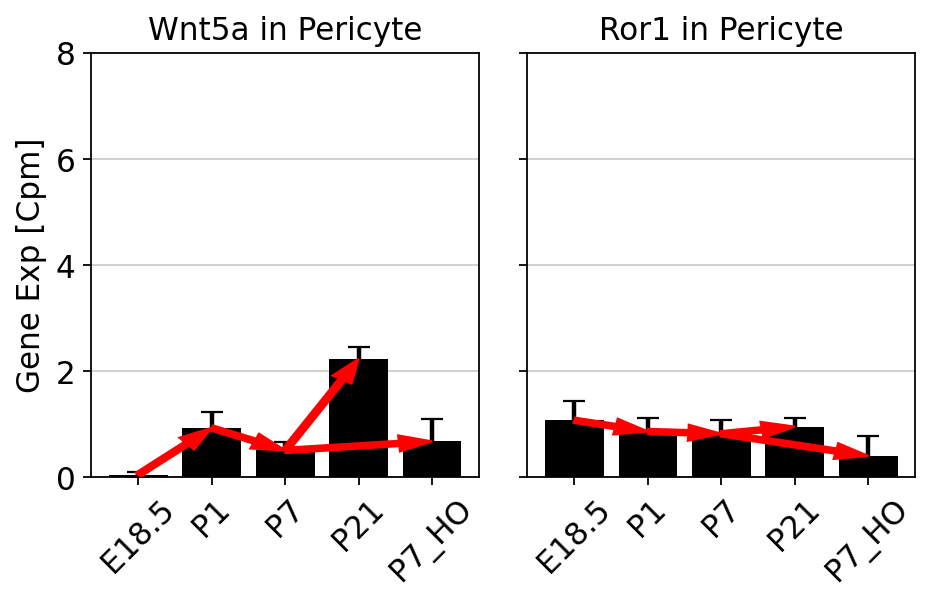

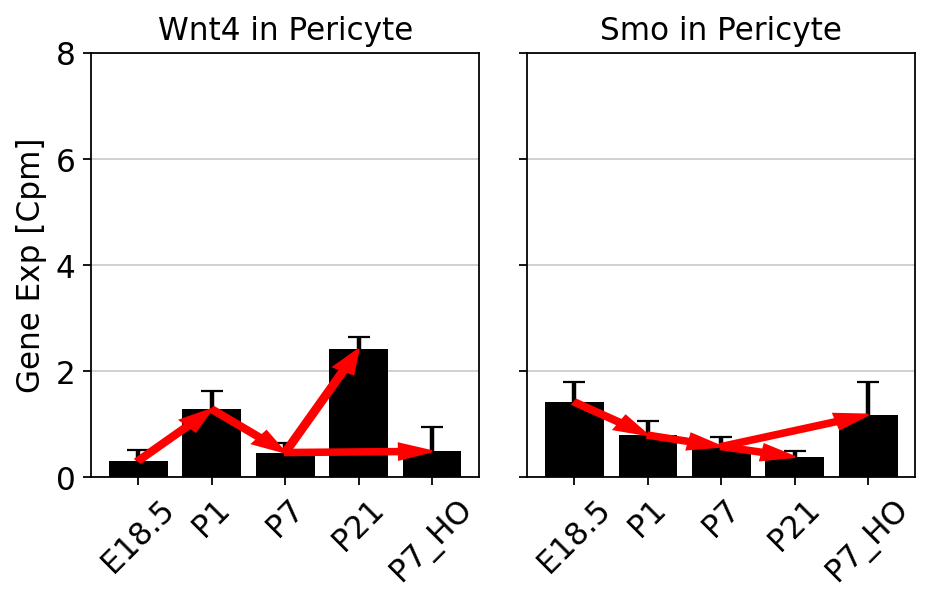

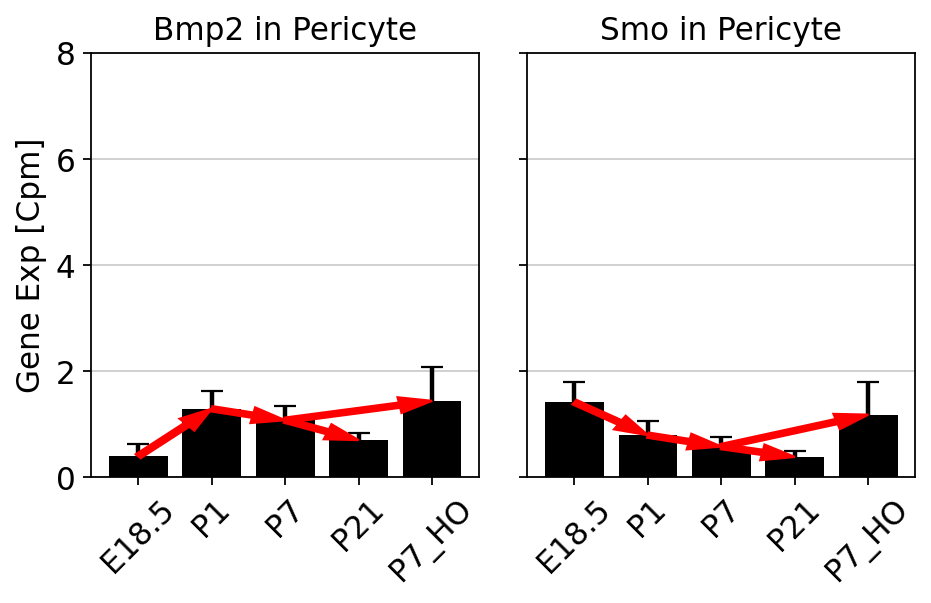

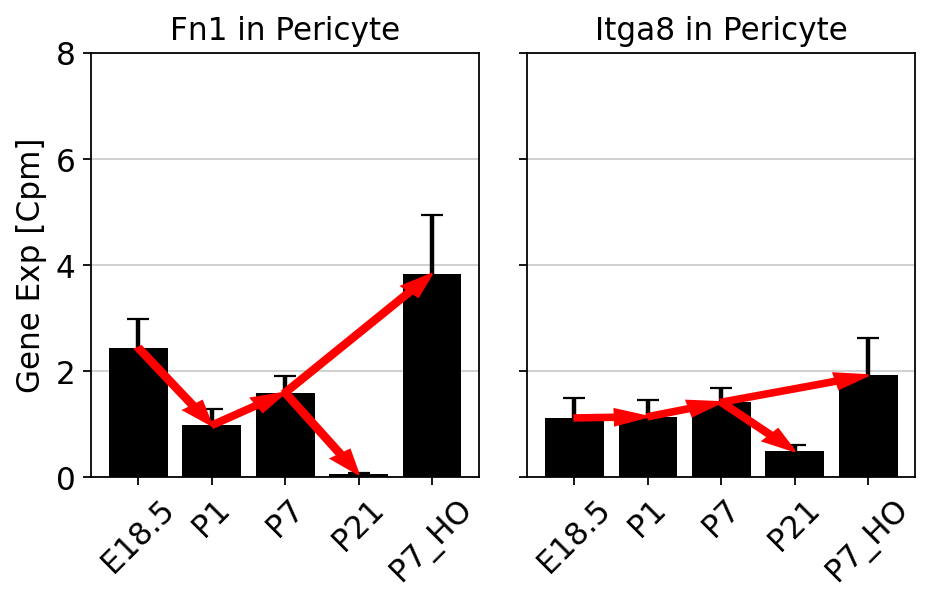

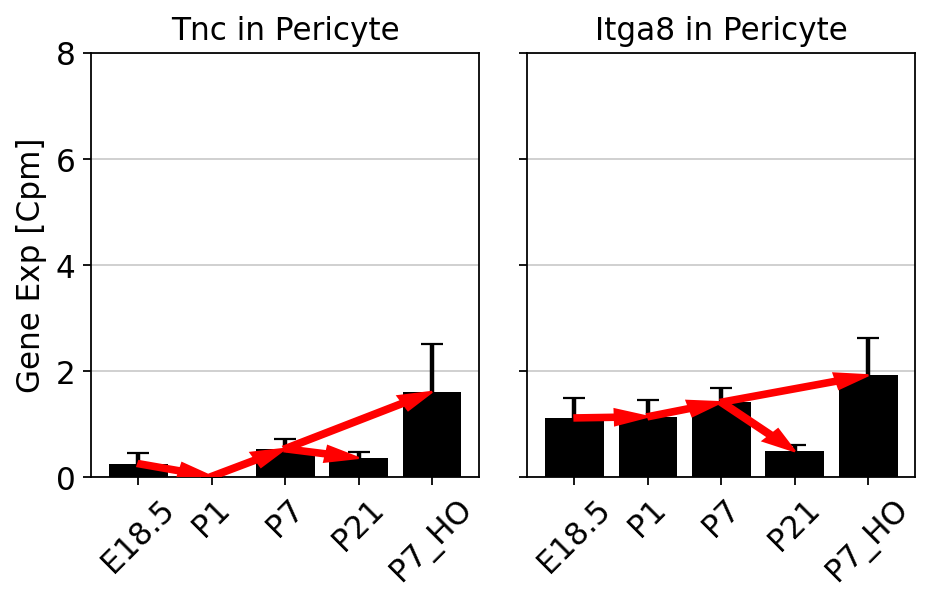

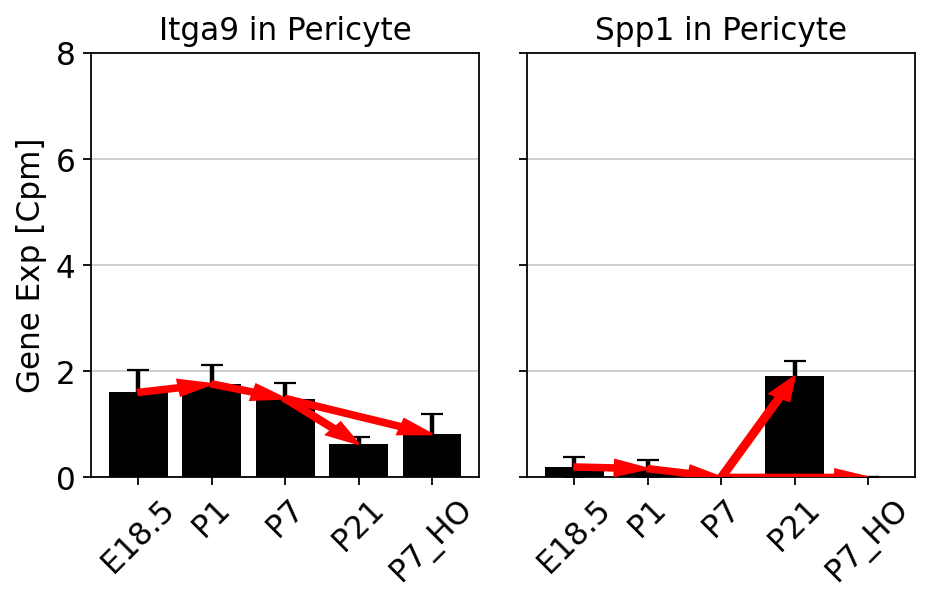

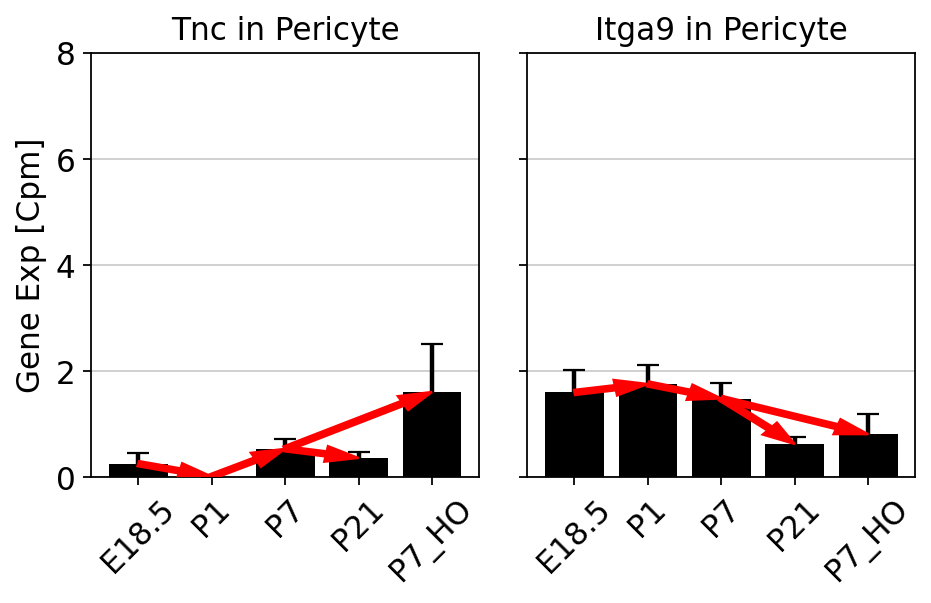

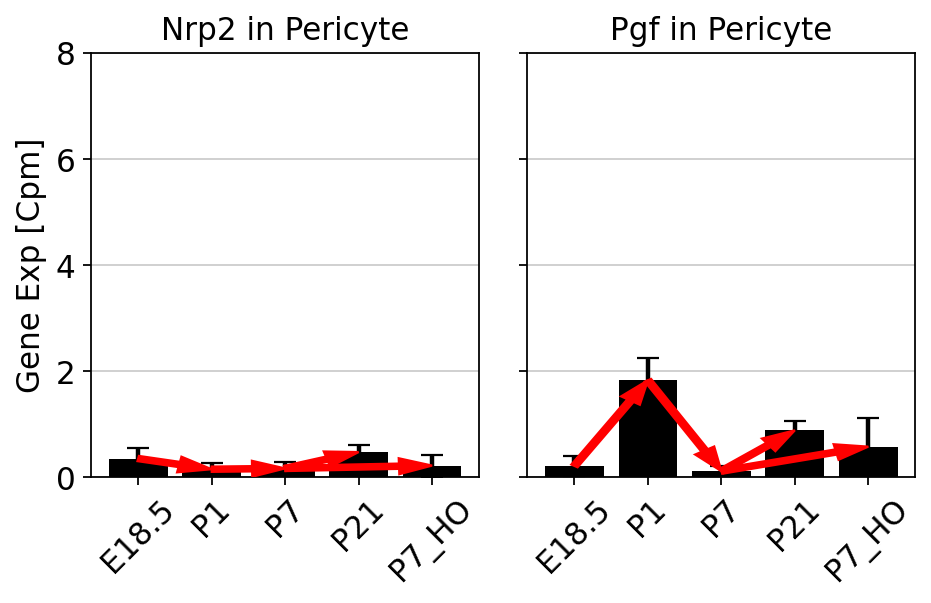

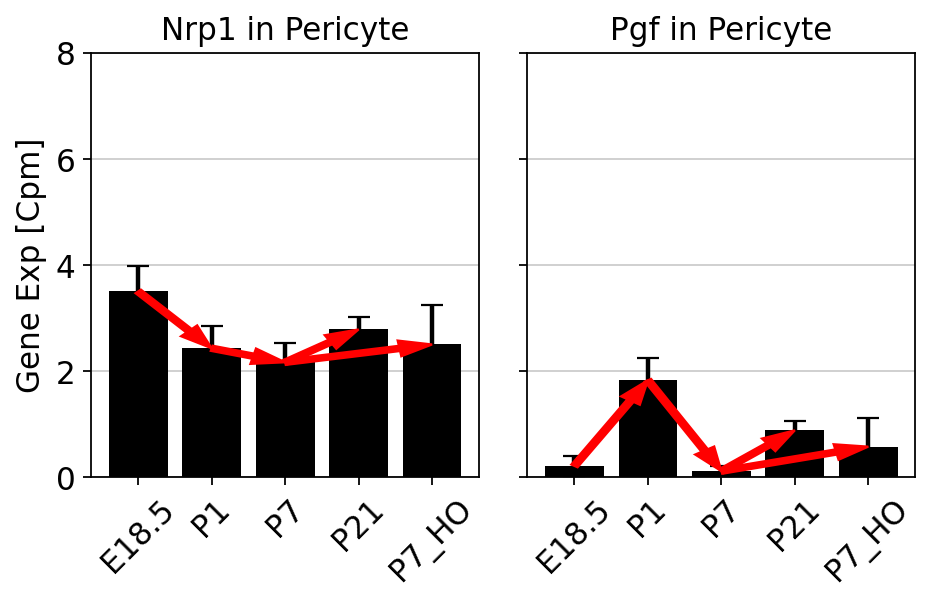

In [134]:
pairs_Car4=[['Itgb1','Col4a1'],['Itgb1','Col1a2'],['Itgb1','Col4a2'],['Itgb1','Col1a1'],
            ['Plaur','Itgb1'],['Plaur','Itga4'],['Plaur','Itgav'],
            ['Fbn1','Itgb1'],['Fbn1','Itga5'],
            ['Nectin3','Cadm1'],
            ['Itgb1','Lamc1'],
            ['Itgb1','Cspg4'],
            ['Pdgfb','Pdgfrb'],
            ['Sirpa','Cd47'],
            ['Sema7a','Itgb1']]
pairs_Early_Car4=[['Col15a1','Itga1'],['Col15a1','Itgb1'],['Col18a1','Itga1'],['Col18a1','Itgb1'],
                  ['Dll1','Notch1'],['Dll1','Notch2'],['Dll1','Notch3'],['Dll1','Notch4'],
                  ['Cxcl12','Cxcr4'],
                  ['Bmp6','Bmpr2'],['Bmp6','Acvr2a'],['Bmp6','Bmpr1a'],['Bmp6','Acvr1'],['Bmp6','Acvr2b'],
                  ['Fzd6','Wnt5a'],['Fzd6','Wnt4'],['Fzd3','Wnt5a'],
                  ['Gas6','Axl'],['Il15ra','Axl'],['Il15ra','Il15'],
                  ['Clcf1','Il6st'],['Clcf1','Lifr']]
pairs_pericyte=[['Cadm1','Cadm1'],
                ['Cd44','Hbegf'],['Cd44','Hgf'],['Cd44','Spp1'],
                ['Wnt5a','Fzd1'],['Wnt4','Fzd1'],
                ['Bmpr1a','Bmp2'],['Bmpr1a','Bmp4'],['Bmpr1a','Bmp5'],
                ['Wnt5a','Ror1'],['Wnt4','Smo'],['Bmp2','Smo'],
                ['Fn1','Itga8'],['Tnc','Itga8'],
                ['Itga9','Spp1'],['Tnc','Itga9'],
                ['Nrp2','Pgf'],['Nrp1','Pgf']]
pairs_cts=[['Car4+ capillaries','Pericyte'],['Early Car4- capillaries','Pericyte'],['Pericyte','Pericyte']]
pairs_dic={'Car4+ capillaries':pairs_Car4,'Early Car4- capillaries':pairs_Early_Car4,'Pericyte':pairs_pericyte}
adata_dic={'Pericyte':[
                    adata_d[('Pericyte','E18.5')],
                    adata_d[('Pericyte','P1')],
                    adata_d[('Pericyte','P7')],
                    adata_d[('Pericyte','P21')],
                    adata_d[('Pericyte','P7_HO')]
                        ],
           'Car4+ capillaries':[
                    adata_d[('Car4+ capillaries','E18.5')],
                    adata_d[('Car4+ capillaries','P1')],
                    adata_d[('Car4+ capillaries','P7')],
                    adata_d[('Car4+ capillaries','P21')],
                    adata_d[('Car4+ capillaries','P7_HO')]
                       ],
           'Early Car4- capillaries':[
                    adata_d[('Car4- capillaries','E18.5')],
                    adata_d[('Car4- capillaries','P1')],
                    adata_d[('Car4- capillaries','P7')],
                    adata_d[('Car4- capillaries','P21')],
                    adata_d[('Car4- capillaries','P7_HO')]]}
timepoint=['E18.5','P1','P7','P21','P7_HO']
y_gene_ct=[{},{}]
for ct in pairs_cts:
    pairs=pairs_dic[ct[0]]
    for gene in pairs:
        fig,axs=plt.subplots(1,2,figsize=(6,4),sharey=True)
        for k,(gene_k,ct_k) in enumerate(zip(gene,ct)): 
            y_gene_ct[k][(gene_k,ct_k)]=[]
            x=[0,1,2,3,4]
            y=[]
            sem_gene_ct=[]
            x_arrow=[0,1,2,3,4]
            y_arrow=[] 
            for j,tp in enumerate(timepoint):
                gene_ct=adata_dic[ct_k][j][:,gene_k].X.toarray()[:,0]
                y_gene_ct[k][(gene_k,ct_k)].append(gene_ct)
                y.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
                sem_gene_ct.append((y_gene_ct[k][(gene_k,ct_k)][j]).std()/np.sqrt((y_gene_ct[k][(gene_k,ct_k)][j]).size))
                y_arrow.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
            ax=axs[k]
            ax=sns.barplot(x,y,label='_nolegend_',lw=2,ax=ax,color='black',zorder=10) 
            ax.errorbar(x,y,yerr=sem_gene_ct,color='black',ls='',capsize=5,label='sem',lw=2)
            ax.set_title(gene_k+' in '+ct_k)
            ax.set_ylim(0,8)
            ax.set_xticklabels(['E18.5','P1','P7','P21','P7_HO'],rotation=45)
            for a in range(3): 
                ax.arrow(x_arrow[a],y_arrow[a],x_arrow[a+1]-x_arrow[a],y_arrow[a+1]-y_arrow[a],length_includes_head=True,color='red',zorder=10,width=0.1)
            ax.arrow(x_arrow[2],y_arrow[2],x_arrow[4]-x_arrow[2],y_arrow[4]-y_arrow[2],length_includes_head=True,color='red',zorder=10,width=0.1) 
            if k==0:
                ax.set_ylabel('Gene Exp [Cpm]') 
        plt.tight_layout()
        plt.subplots_adjust(left=0.1)
        fig.savefig('figures/interaction_endo_peri/timepoint/'+gene[0]+' in '+ct[0]+' & '+gene[1]+' in '+ct[1]+'_timepoint.png')